# Analyse CMIP5 and CMIP6 ODSL data and plot

In [853]:
import sys

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../Project_ProbSLR/CMIP_SeaLevel/code/')
import mod_loc as loc
import mod_postpro as pp

sys.path.append('../SLBudget/code/')
import SeaLevelContrib as slc

import regionmask
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from scipy.stats import linregress, ttest_ind

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Prepare CMIP data

### Read datasets of CMIP data

In [567]:
def read_zos_ds(data_dir, mip, sce):
    '''Read both historical and scenario datasets, select the common 
    models and concatenate the two datasets'''
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_historical/{mip}_zos_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_{sce}/{mip}_zos_{sce}_*.nc')

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
    
    return tot_ds

In [13]:
# Check two path:
# ../Project_ProbSLR/CMIP_SeaLevel/outputs

# ../Project_ProbSLR/Data_Proj/Data_cmip5
# ../Project_ProbSLR/Data_Proj/Data_cmip6

In [351]:
cmip5_data_dir = '../Project_ProbSLR/Data_Proj/Data_cmip5'
cmip6_data_dir = '../Project_ProbSLR/Data_Proj/Data_cmip6'


In [352]:
cmip5_26_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp26')
cmip5_45_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp45')
cmip5_85_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp85')

cmip6_126_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp126')
cmip6_245_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp245')
cmip6_585_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp585')

In [353]:
# Select CMIP5 model intersection
cmip5_models = sorted(list(set(cmip5_26_zos.model.data) & 
                           set(cmip5_45_zos.model.data) & 
                           set(cmip5_85_zos.model.data)))

cmip5_26_zos = cmip5_26_zos.sel(model=cmip5_models)
cmip5_45_zos = cmip5_45_zos.sel(model=cmip5_models)
cmip5_85_zos = cmip5_85_zos.sel(model=cmip5_models)

print(f'Using {len(cmip5_models)} cmip5 models: \n {cmip5_models}')

Using 20 cmip5 models: 
 ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-R', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m']


In [354]:
# Select CMIP6 model intersection
cmip6_models = sorted(list(set(cmip6_126_zos.model.data) & 
                           set(cmip6_245_zos.model.data) & 
                           set(cmip6_585_zos.model.data)))

cmip6_126_zos = cmip6_126_zos.sel(model=cmip6_models)
cmip6_245_zos = cmip6_245_zos.sel(model=cmip6_models)
cmip6_585_zos = cmip6_585_zos.sel(model=cmip6_models)

print(f'Using {len(cmip6_models)} cmip6 models: \n {cmip6_models}')

Using 29 cmip6 models: 
 ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']


### Select region of interest and tranform dataset to dataframe

In [355]:
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

ECE3_126_zos = cmip6_126_zos.CorrectedReggrided_zos.sel(model='EC-Earth3').isel(time=0)

# Define the mask and change its value from 0 to 1
mask_cmip = NLregion.mask_3D(ECE3_126_zos.lon, ECE3_126_zos.lat)



Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

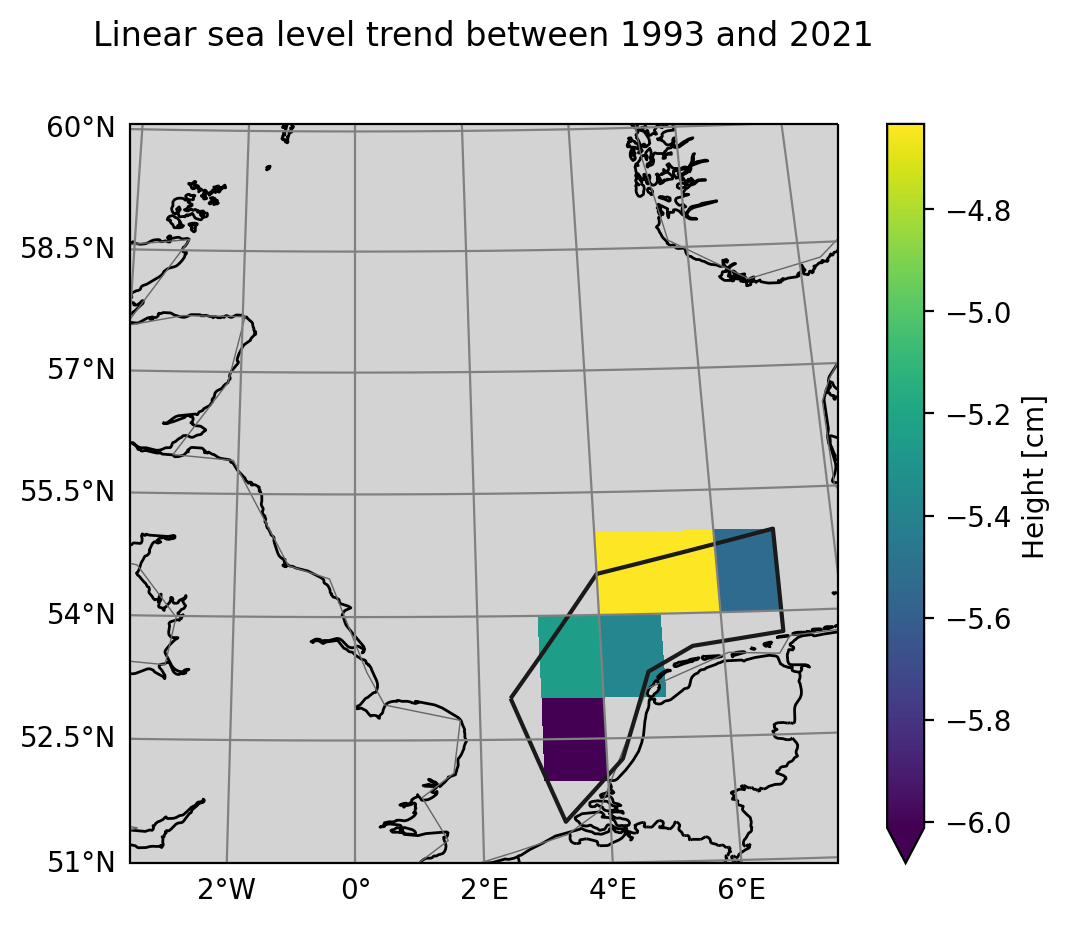

In [356]:
ECE3_126_zos_m = ECE3_126_zos.where(mask_cmip)

p = ECE3_126_zos_m.sel(lon=slice(lon_min-1,lon_max+1), 
                       lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'Height [cm]'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

In [357]:
def ds2df(cmip_ds, polygone_coord, start_year, end_year):
    '''Transform a dataset to a dataframe by averaging sea level over a region'''
    
    region = regionmask.Regions([polygone_coord], names=['Reg'], abbrevs=['Reg'])
    
    # Define the mask and change its value from 0 to 1
    mask_cmip = region.mask_3D(cmip_ds.lon, cmip_ds.lat)
    
    #cmip_ds_m = cmip_ds.CorrectedReggrided_zos.where(mask_cmip)
    
    weights = np.cos(np.deg2rad(cmip_ds.lat))

    sel_da = cmip_ds.weighted(mask_cmip * weights).mean(dim=('lat', 'lon'))

    df = pd.DataFrame(dict(time=np.arange(start_year,end_year)+0.5))
    df = df.set_index('time')

    for mod in sel_da.model.values:
        df[mod] = sel_da.sel(model=mod).isel(region=0).drop_vars(
            ['model', 'region', 'abbrevs', 'names']).to_dataframe()
        
    return df

In [358]:
start_year = 1900 #1970 #2006
end_year = 2100

cmip5_26_df = ds2df(cmip5_26_zos, NL, start_year, end_year)
cmip5_45_df = ds2df(cmip5_45_zos, NL, start_year, end_year)
cmip5_85_df = ds2df(cmip5_85_zos, NL, start_year, end_year)

cmip6_126_df = ds2df(cmip6_126_zos, NL, start_year, end_year)
cmip6_245_df = ds2df(cmip6_245_zos, NL, start_year, end_year)
cmip6_585_df = ds2df(cmip6_585_zos, NL, start_year, end_year)

### Read wind influence on sea level data and check their effect on the time series

In [421]:
wind_hist_ds = xr.open_dataset(f'{cmip6_data_dir}/wind_influence_sealevel_DutchCoast/timeseries_cmip6.nc')
wind_126_ds = xr.open_dataset(f'{cmip6_data_dir}/wind_influence_sealevel_DutchCoast/timeseries_cmip6_ssp126.nc')
wind_245_ds = xr.open_dataset(f'{cmip6_data_dir}/wind_influence_sealevel_DutchCoast/timeseries_cmip6_ssp245.nc')
wind_585_ds = xr.open_dataset(f'{cmip6_data_dir}/wind_influence_sealevel_DutchCoast/timeseries_cmip6_ssp585.nc')

cmip6_wind_and_zos_models = sorted(list(set(wind_hist_ds.model.data) & 
                                        set(wind_126_ds.model.data)& 
                                        set(wind_245_ds.model.data) & 
                                        set(wind_585_ds.model.data) & 
                                        set(cmip6_models)))

wind_hist_ds = wind_hist_ds.sel(model=cmip6_wind_and_zos_models)
wind_126_ds = wind_126_ds.sel(model=cmip6_wind_and_zos_models)
wind_245_ds = wind_245_ds.sel(model=cmip6_wind_and_zos_models)
wind_585_ds = wind_585_ds.sel(model=cmip6_wind_and_zos_models)


In [422]:
len(cmip6_wind_and_zos_models)

26

Three models have zos data but no wind influence data for historical and the three emission scenarios

Now we tranform the data into dataframe to easily remove it to the zos data.

In [423]:
def wind_ds2df(wind_ds):
    '''Transform a dataset to a dataframe'''

    sel_da = wind_ds.wind_total.sel(station='Average').drop('station')
    
    df = pd.DataFrame(dict(time=wind_ds.time))
    df = df.set_index('time')

    for mod in sel_da.model.values:
        df[mod] = sel_da.sel(model=mod).drop_vars('model').to_dataframe()
        
    return df

In [424]:
wind_hist_df = wind_ds2df(wind_hist_ds)
wind_126_df = pd.concat([wind_hist_df,wind_ds2df(wind_126_ds)])
wind_245_df = pd.concat([wind_hist_df,wind_ds2df(wind_245_ds)])
wind_585_df = pd.concat([wind_hist_df,wind_ds2df(wind_585_ds)])


In [484]:
cmip6_126_wind_df = cmip6_126_df[cmip6_wind_and_zos_models].join(wind_126_df, rsuffix='_wind', how='inner')
cmip6_245_wind_df = cmip6_245_df[cmip6_wind_and_zos_models].join(wind_245_df, rsuffix='_wind', how='inner')
cmip6_585_wind_df = cmip6_585_df[cmip6_wind_and_zos_models].join(wind_585_df, rsuffix='_wind', how='inner')

In [485]:
for m in cmip6_wind_and_zos_models:
    cmip6_126_wind_df[f'{m}_nowind'] = cmip6_126_wind_df[m] - cmip6_126_wind_df[f'{m}_wind']
    cmip6_245_wind_df[f'{m}_nowind'] = cmip6_245_wind_df[m] - cmip6_245_wind_df[f'{m}_wind']
    cmip6_585_wind_df[f'{m}_nowind'] = cmip6_585_wind_df[m] - cmip6_585_wind_df[f'{m}_wind']
    

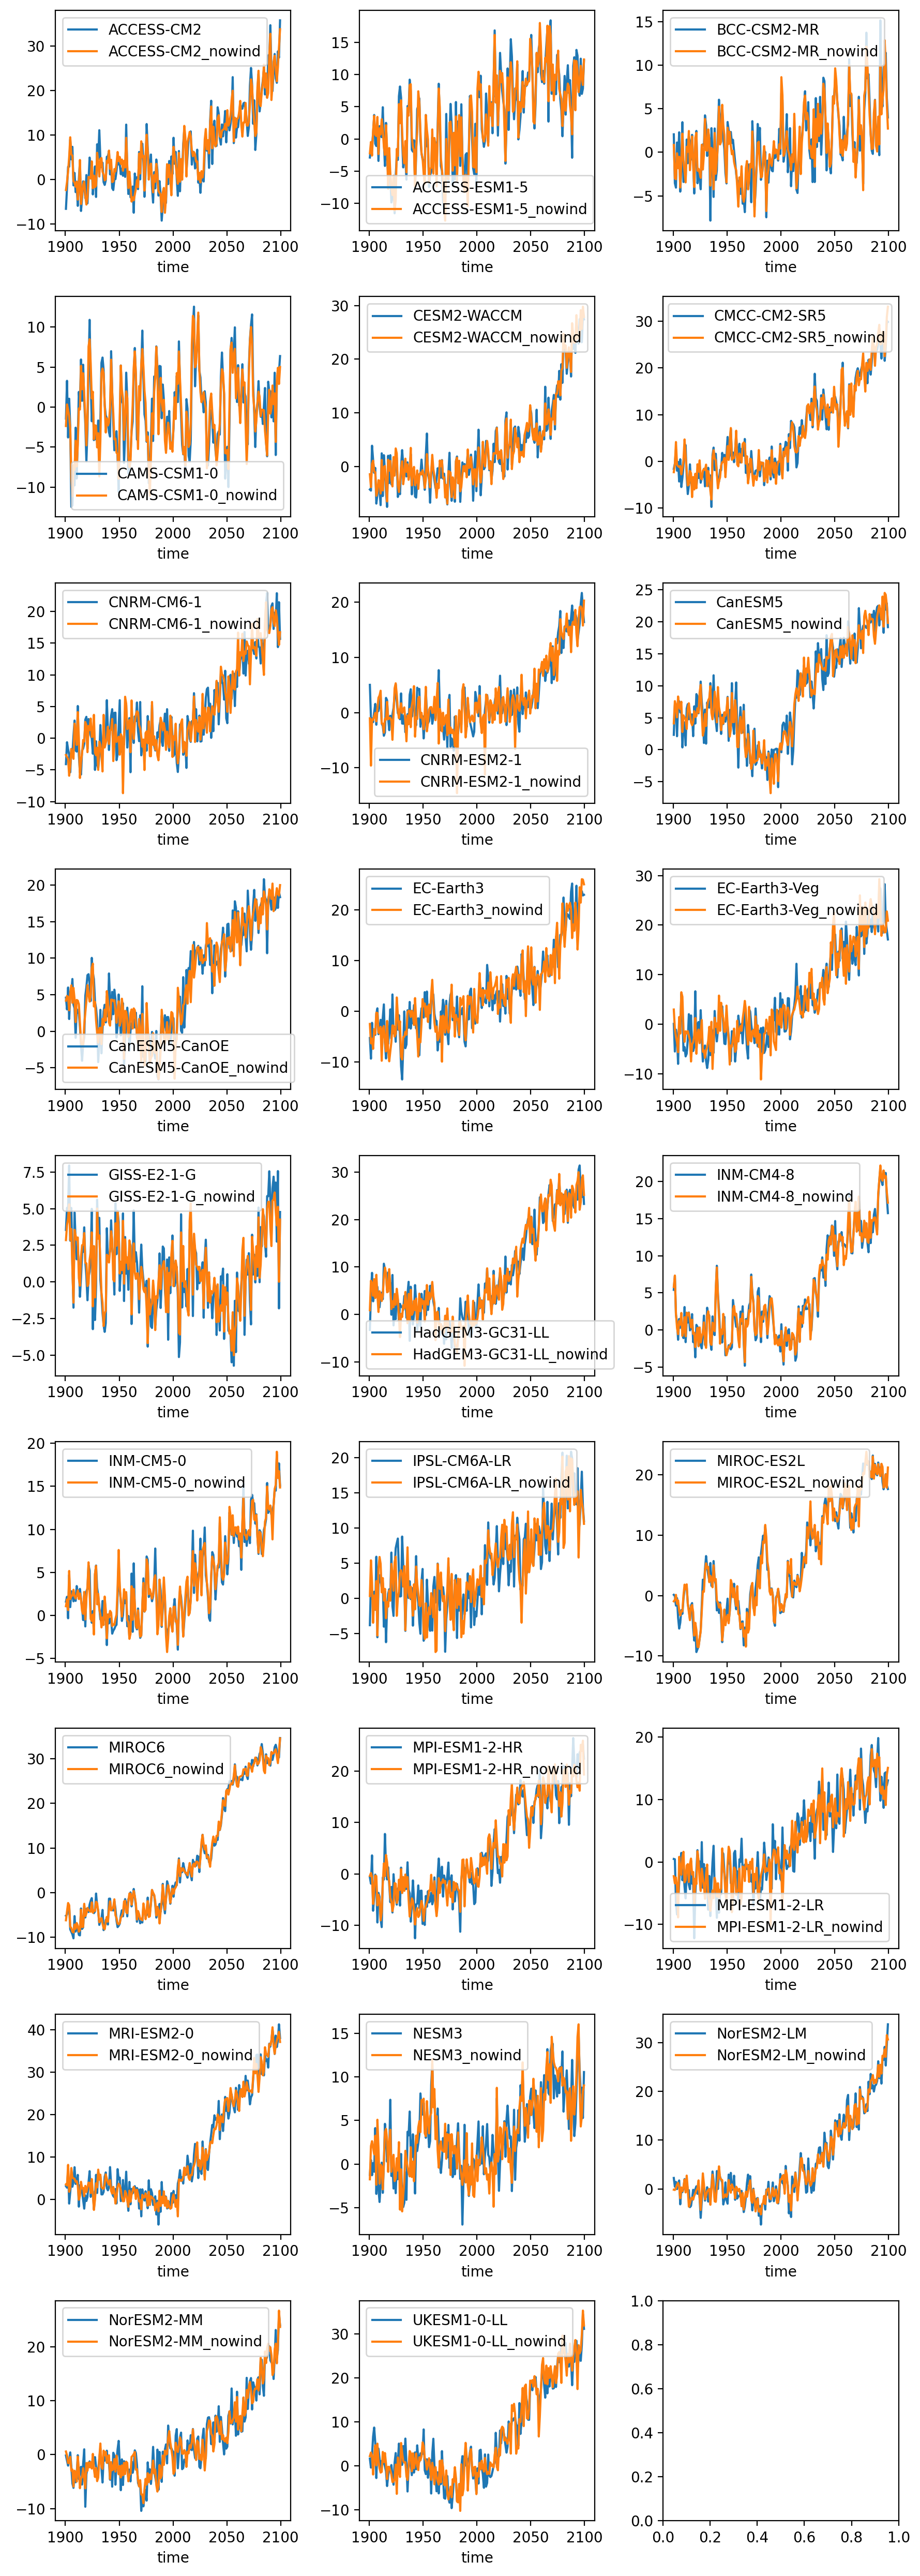

In [503]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(9, 25))

for idx, m in enumerate(cmip6_wind_and_zos_models):
    cmip6_585_wind_df.loc[:,m].plot(ax=axes.flat[idx], legend=True)
    cmip6_585_wind_df.loc[:,f'{m}_nowind'].plot(ax=axes.flat[idx], legend=True)
    
plt.tight_layout()

plt.savefig('figures/compare_cmip6_wind_nowind.pdf', dpi=150)

Check the reduction of the variability from wind over the period with small trend 1900-2000:

In [487]:
print('Period 1900:2000')
print('Standard deviation before and after wind removal and percentage of variance reduction from wind:')

for idx, m in enumerate(cmip6_wind_and_zos_models):
    std_before = cmip6_245_wind_df.loc[1900:2000,m].std()
    std_after = cmip6_245_wind_df.loc[1900:2000,f'{m}_nowind'].std()
    pvar_wind = (std_before**2-std_after**2)*100/std_before**2
    mstr = '{:16}'.format(m)
    print(f'{mstr}: {round(std_before,2)}, {round(std_after,2)}, {round(pvar_wind,1)}' )
    

Period 1900:2000
Standard deviation before and after wind removal and percentage of variance reduction from wind:
ACCESS-CM2      : 4.33, 3.77, 24.3
ACCESS-ESM1-5   : 4.86, 4.69, 6.9
BCC-CSM2-MR     : 3.0, 2.45, 32.9
CAMS-CSM1-0     : 4.87, 4.47, 15.7
CESM2-WACCM     : 2.95, 2.33, 37.3
CMCC-CM2-SR5    : 2.99, 2.92, 4.2
CNRM-CM6-1      : 2.89, 2.85, 3.2
CNRM-ESM2-1     : 2.87, 3.05, -12.8
CanESM5         : 3.88, 3.9, -1.2
CanESM5-CanOE   : 3.43, 3.13, 17.0
EC-Earth3       : 3.58, 3.53, 2.7
EC-Earth3-Veg   : 3.48, 3.35, 7.3
GISS-E2-1-G     : 2.52, 1.99, 37.3
HadGEM3-GC31-LL : 4.16, 4.0, 7.6
INM-CM4-8       : 2.65, 2.43, 15.8
INM-CM5-0       : 2.45, 2.32, 10.0
IPSL-CM6A-LR    : 3.42, 3.17, 13.9
MIROC-ES2L      : 4.36, 4.07, 12.9
MIROC6          : 2.83, 2.61, 14.7
MPI-ESM1-2-HR   : 3.5, 3.13, 19.8
MPI-ESM1-2-LR   : 3.18, 2.7, 27.7
MRI-ESM2-0      : 2.8, 2.36, 29.3
NESM3           : 3.37, 3.11, 14.8
NorESM2-LM      : 2.28, 1.87, 32.4
NorESM2-MM      : 2.9, 2.4, 31.4
UKESM1-0-LL     : 3.88, 

### Compute linear sea level trends

In [488]:
def compute_linregress_trend_error(df):
    ''' Compute the trend and error in the trend given an dataframe of ODSL time 
    series for each models'''
    
    df = df*10 # Convert height from cm to mm
    
    length = np.arange(15,51,5)
    end_year = np.arange(1960,2031,5)
    
    slope = np.zeros([len(df.columns), len(length), len(end_year)])
    stderr = np.zeros([len(df.columns), len(length), len(end_year)])
    
    for idx_l, l in enumerate(length):
        for idx_ey, ey in enumerate(end_year):
            for m in range(len(df.columns)):
                sel_df = df.loc[ey-l:ey,:].iloc[:,m]
                res = linregress(sel_df.index, sel_df)

                slope[m,idx_l,idx_ey] = res.slope
                stderr[m,idx_l,idx_ey] = res.stderr
    
    ds = xr.Dataset({'slope': (['model', 'length', 'end_year'], slope), 
                     'stderr': (['model', 'length', 'end_year'], stderr)},
                   coords={'model': ('model', df.columns),
                          'length': ('length', length),
                          'end_year': ('end_year', end_year)} )
        
    return ds
    

In [620]:
cmip5_ds = compute_linregress_trend_error(cmip5_45_df)

# Use all cmip6 models
#cmip6_ds = compute_linregress_trend_error(cmip6_245_df)

# Use only models that also have wind data
cmip6_ds = compute_linregress_trend_error(
    cmip6_245_wind_df.loc[:,~cmip6_245_wind_df.columns.str.contains('wind')])

cmip6_nowind_ds = compute_linregress_trend_error(
    cmip6_245_wind_df.loc[:,cmip6_245_wind_df.columns.str.contains('_nowind')])



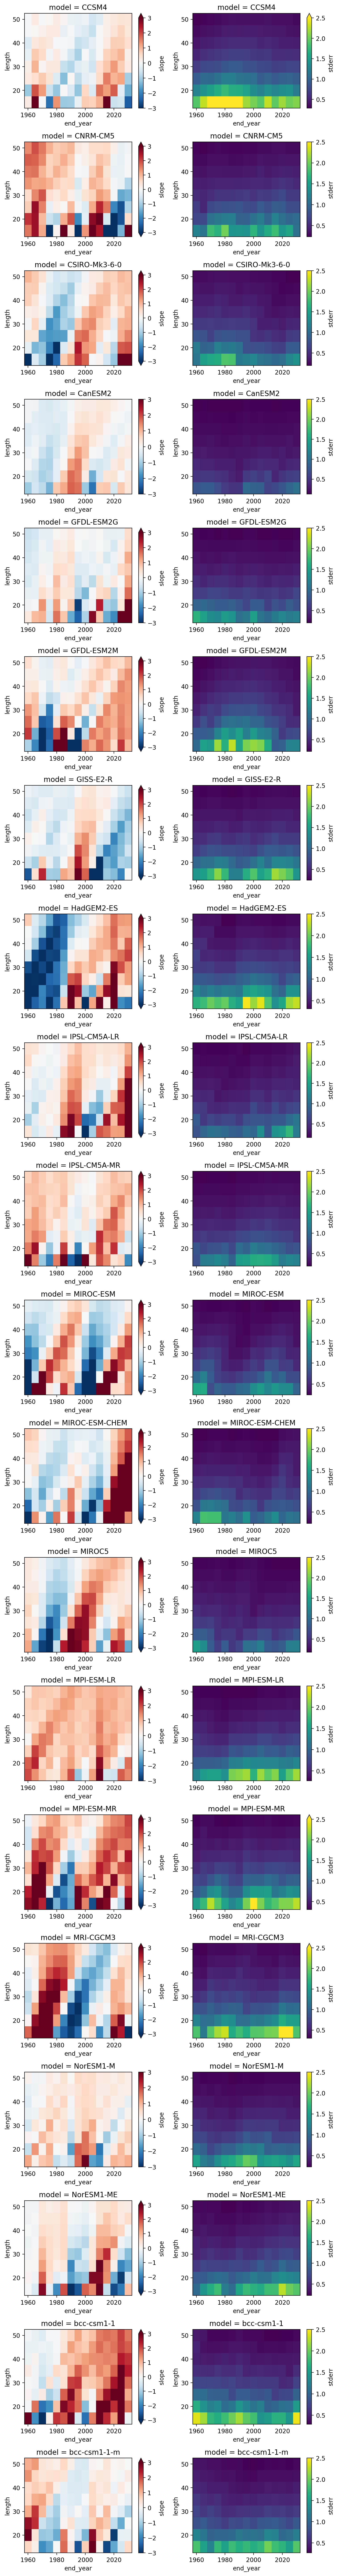

In [600]:
fig, axes = plt.subplots(nrows=len(cmip5_ds.model), ncols=2, figsize=(8, len(cmip5_ds.model)*3))

for idx, model in enumerate(cmip5_ds.model):
    cmip5_ds.slope.sel(model=model).plot(ax=axes[idx,0], vmin=-3, vmax=3, cmap='RdBu_r')
    cmip5_ds.stderr.sel(model=model).plot(ax=axes[idx,1], vmax=2.5)
    
plt.tight_layout()

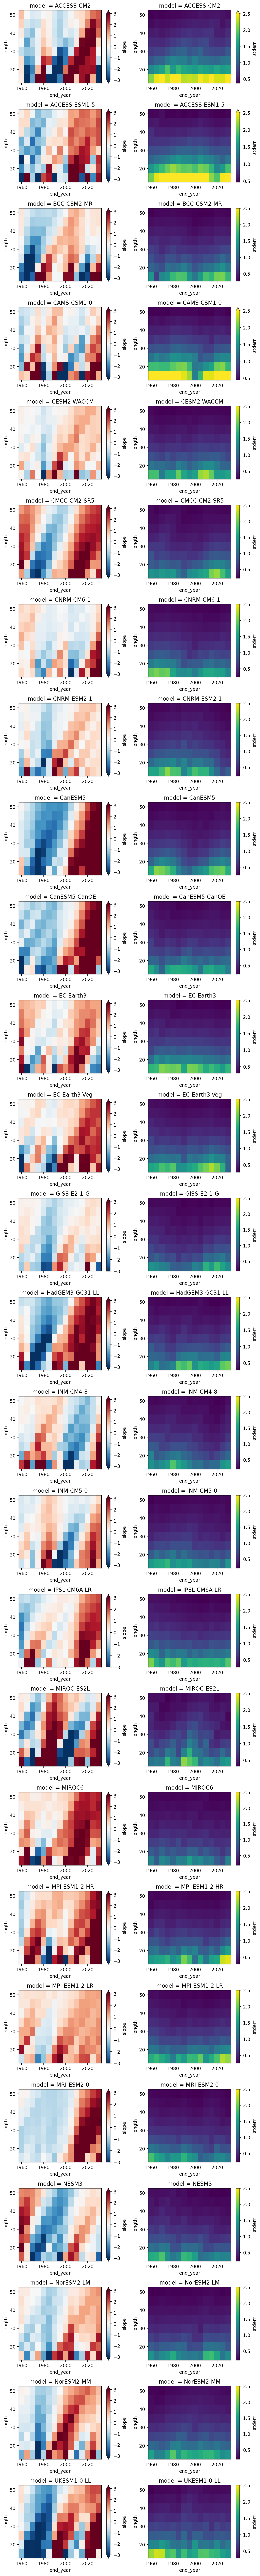

In [601]:
fig, axes = plt.subplots(nrows=len(cmip6_ds.model), ncols=2, figsize=(8, len(cmip6_ds.model)*3))

for idx, model in enumerate(cmip6_ds.model):
    cmip6_ds.slope.sel(model=model).plot(ax=axes[idx,0], vmin=-3, vmax=3, cmap='RdBu_r')
    cmip6_ds.stderr.sel(model=model).plot(ax=axes[idx,1], vmax=2.5)
    
plt.tight_layout()

### Compute values for the end of the century

In [609]:
for sd in [2080,2090]:
    cmip5_ds[f'val_26_{sd}_2100'] = (('model'), cmip5_26_df.loc[sd:2100].mean(axis=0))
    cmip5_ds[f'val_45_{sd}_2100'] = (('model'), cmip5_45_df.loc[sd:2100].mean(axis=0))
    cmip5_ds[f'val_85_{sd}_2100'] = (('model'), cmip5_85_df.loc[sd:2100].mean(axis=0))
    
    cmip6_ds[f'val_126_{sd}_2100'] = (('model'), cmip6_126_wind_df.loc[
        sd:2100, ~cmip6_126_wind_df.columns.str.contains('wind')].mean(axis=0))
    cmip6_ds[f'val_245_{sd}_2100'] = (('model'), cmip6_245_wind_df.loc[
        sd:2100, ~cmip6_245_wind_df.columns.str.contains('wind')].mean(axis=0))
    cmip6_ds[f'val_585_{sd}_2100'] = (('model'), cmip6_585_wind_df.loc[
        sd:2100, ~cmip6_585_wind_df.columns.str.contains('wind')].mean(axis=0))
    
    val126 = cmip6_126_wind_df.loc[sd:2100, 
                              cmip6_126_wind_df.columns.str.contains('_nowind')
                             ].mean(axis=0)
    val245 = cmip6_245_wind_df.loc[sd:2100, 
                              cmip6_245_wind_df.columns.str.contains('_nowind')
                             ].mean(axis=0)
    val585 = cmip6_585_wind_df.loc[sd:2100, 
                              cmip6_585_wind_df.columns.str.contains('_nowind')
                             ].mean(axis=0)
    
    cmip6_nowind_ds[f'val_126_{sd}_2100'] = (('model'), val126)
    cmip6_nowind_ds[f'val_245_{sd}_2100'] = (('model'), val245)
    cmip6_nowind_ds[f'val_585_{sd}_2100'] = (('model'), val585)
    

## Compare time series of mean ODSL

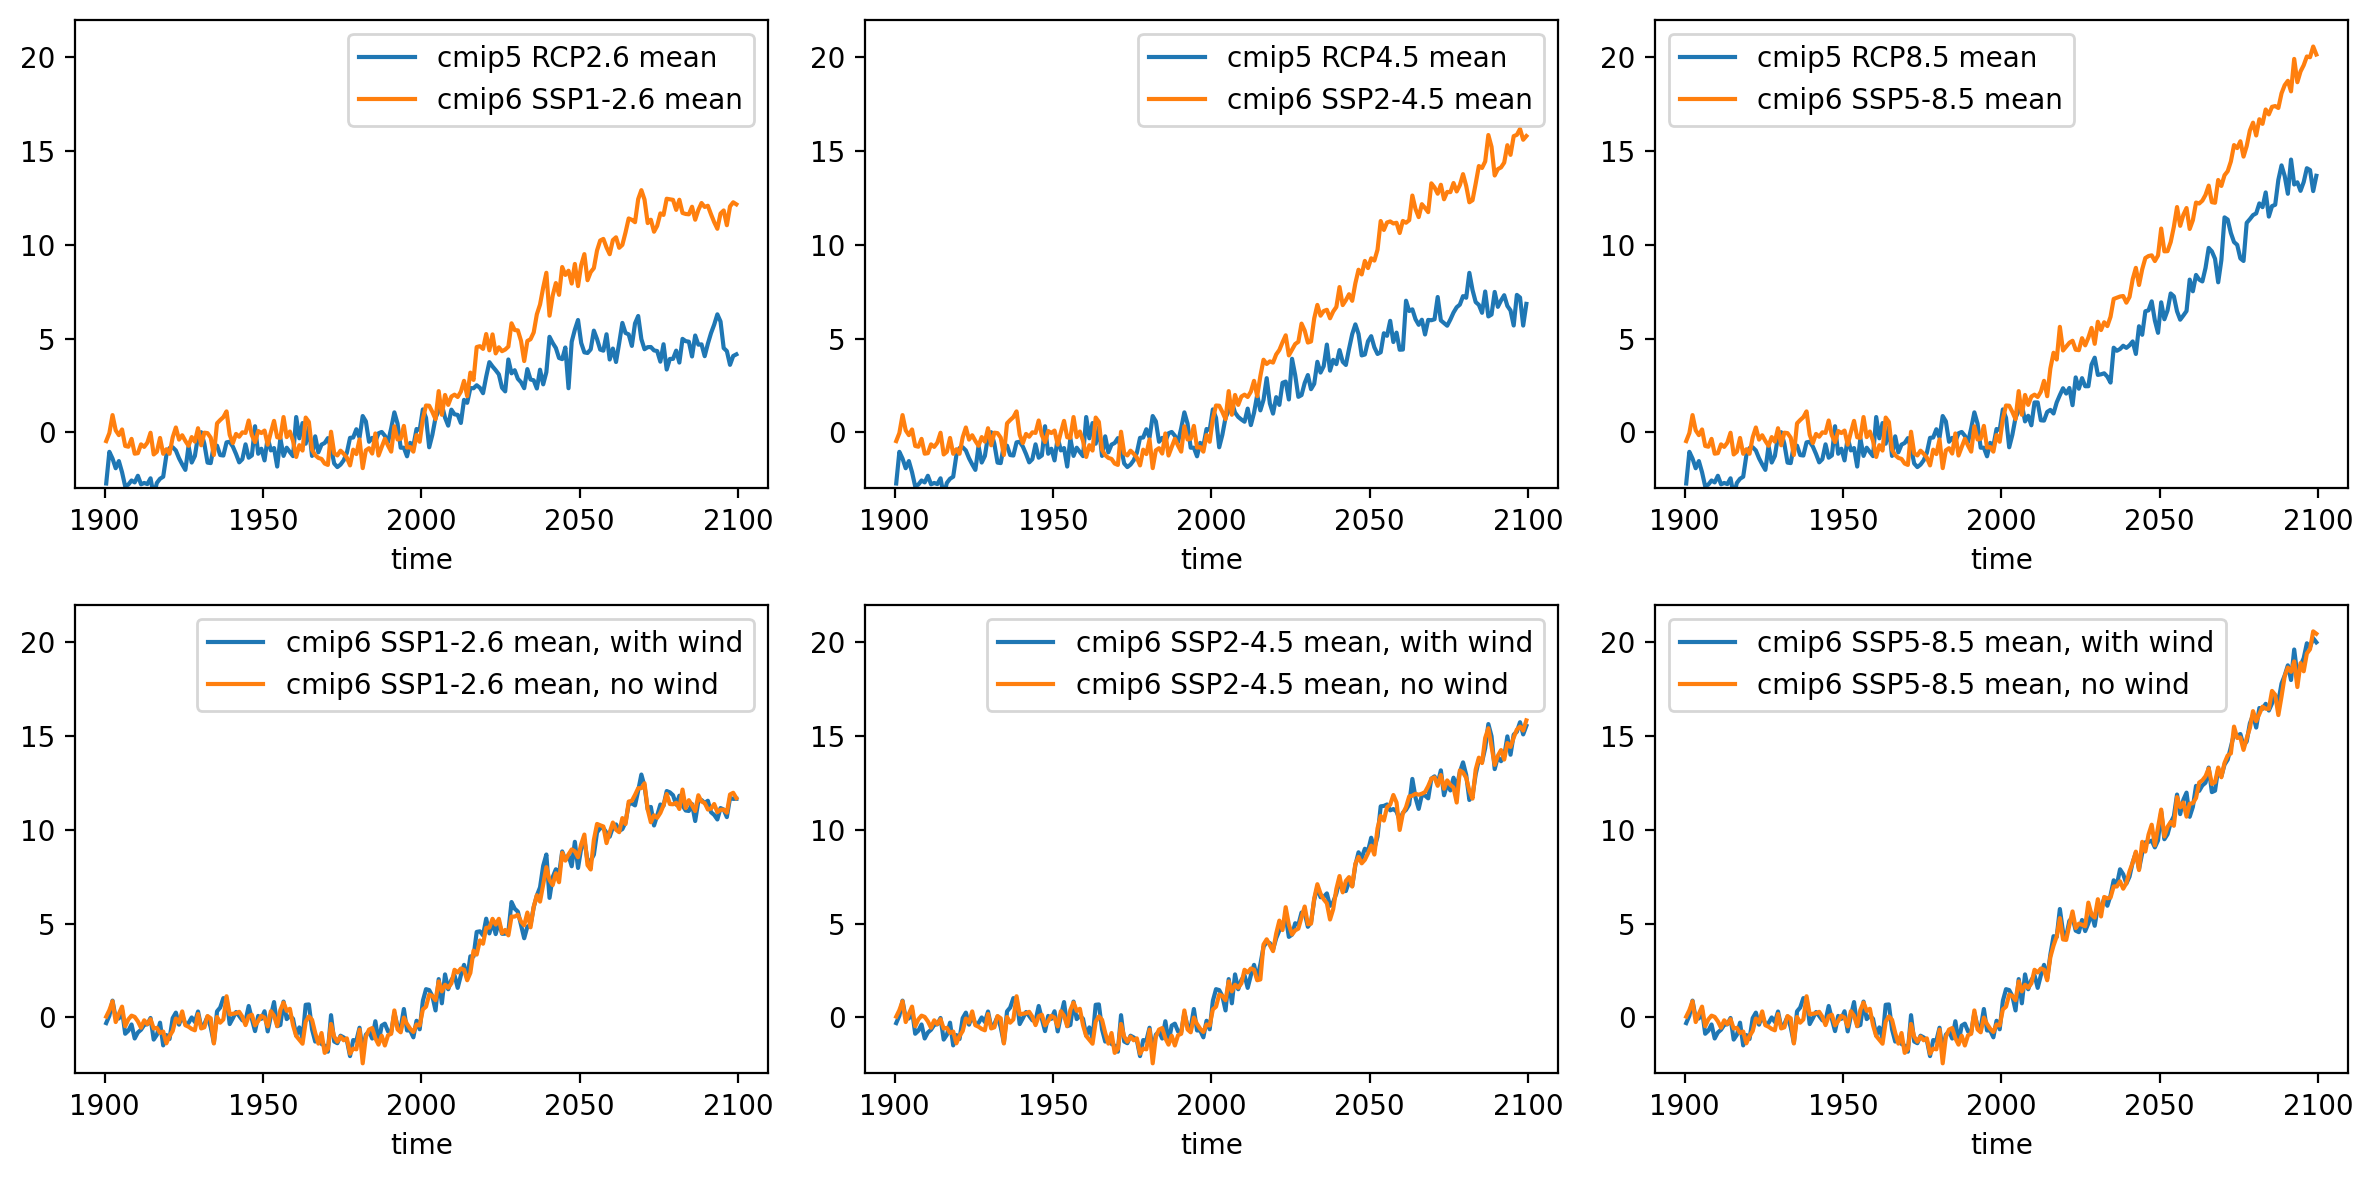

In [610]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

list_cmip5 = [cmip5_26_df, cmip5_45_df, cmip5_85_df]
list_cmip6 = [cmip6_126_df, cmip6_245_df, cmip6_585_df]
list_cmip6_wind = [cmip6_126_wind_df, cmip6_245_wind_df, cmip6_585_wind_df]

cmip5_scen = ['RCP2.6', 'RCP4.5', 'RCP8.5']
cmip6_scen = ['SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5']

for i in range(3):
    mean_s = list_cmip5[i].mean(axis=1)
    mean_s.name = f'cmip5 {cmip5_scen[i]} mean'
    mean_s.plot(legend=True, ax=axes[0,i])
    
    mean_s = list_cmip6[i].mean(axis=1)
    mean_s.name = f'cmip6 {cmip6_scen[i]} mean'
    mean_s.plot(legend=True, ax=axes[0,i])
    
    with_wind = ~list_cmip6_wind[i].columns.str.contains('wind')
    mean_s = list_cmip6_wind[i].loc[:,with_wind].mean(axis=1)
    mean_s.name = f'cmip6 {cmip6_scen[i]} mean, with wind'
    mean_s.plot(legend=True, ax=axes[1,i])
    
    no_wind = list_cmip6_wind[i].columns.str.contains('_nowind')
    mean_s = list_cmip6_wind[i].loc[:,no_wind].mean(axis=1)
    mean_s.name = f'cmip6 {cmip6_scen[i]} mean, no wind'
    mean_s.plot(legend=True, ax=axes[1,i])
    
    axes[0,i].set_ylim([-3,22])
    axes[1,i].set_ylim([-3,22])
    
plt.tight_layout()

In [611]:
print('Values in cm except for p-value')
print('Null-hypothesis tested with a Welch’s t-test: The two ensembles have the same mean')

rp1 = [1900, 1950]
rp2 = [1986, 2005]
rp3 = [1995, 2014]

for rp in [rp1, rp2, rp3]:
    print(f'Reference period: {rp[0]}-{rp[1]}')
    for i in range(3):
        mean_cmip5_s = list_cmip5[i].mean(axis=1)
        mean_cmip5_diff = (mean_cmip5_s.loc[2090:2101].mean() - 
                           mean_cmip5_s.loc[rp[0]:rp[1]+1].mean() )

        mean_cmip6_s = list_cmip6[i].mean(axis=1)
        mean_cmip6_diff = (mean_cmip6_s.loc[2090:2101].mean() - 
                           mean_cmip6_s.loc[rp[0]:rp[1]+1].mean() )

        diff = mean_cmip6_diff - mean_cmip5_diff

        cmip5_mod_diff = (list_cmip5[i].loc[2090:2101].mean() - 
                          list_cmip5[i].loc[rp[0]:rp[1]+1].mean() )
        cmip6_mod_diff = (list_cmip6[i].loc[2090:2101].mean() - 
                          list_cmip6[i].loc[rp[0]:rp[1]+1].mean() )
        res = ttest_ind(a=cmip5_mod_diff, b=cmip6_mod_diff, equal_var=False)

        print(f'{cmip6_scen[i]}, {cmip5_scen[i]}, diff, p-value:')
        print(f'{round(mean_cmip6_diff,1)}, {round(mean_cmip5_diff,1)}, {round(diff,1)}, {round(res.pvalue,3)}')
    

Values in cm except for p-value
Null-hypothesis tested with a Welch’s t-test: The two ensembles have the same mean
Reference period: 1900-1950
SSP1-2.6, RCP2.6, diff, p-value:
12.0, 6.4, 5.6, 0.024
SSP2-4.5, RCP4.5, diff, p-value:
15.5, 8.2, 7.2, 0.005
SSP5-8.5, RCP8.5, diff, p-value:
19.8, 15.0, 4.8, 0.095
Reference period: 1986-2005
SSP1-2.6, RCP2.6, diff, p-value:
11.7, 4.9, 6.8, 0.004
SSP2-4.5, RCP4.5, diff, p-value:
15.2, 6.7, 8.5, 0.001
SSP5-8.5, RCP8.5, diff, p-value:
19.5, 13.5, 6.0, 0.031
Reference period: 1995-2014
SSP1-2.6, RCP2.6, diff, p-value:
10.6, 4.4, 6.3, 0.006
SSP2-4.5, RCP4.5, diff, p-value:
14.1, 6.2, 7.9, 0.001
SSP5-8.5, RCP8.5, diff, p-value:
18.5, 13.0, 5.5, 0.045


## Compare correlation between current trend and future height

In [612]:
for sd in [2080,2090]:
    cmip5_ds[f'cor_26_{sd}_2100'] = xr.corr(cmip5_ds.slope, cmip5_ds[f'val_26_{sd}_2100'], dim='model')
    cmip5_ds[f'cor_45_{sd}_2100'] = xr.corr(cmip5_ds.slope, cmip5_ds[f'val_45_{sd}_2100'], dim='model')
    cmip5_ds[f'cor_85_{sd}_2100'] = xr.corr(cmip5_ds.slope, cmip5_ds[f'val_85_{sd}_2100'], dim='model')
    
    cmip6_ds[f'cor_126_{sd}_2100'] = xr.corr(cmip6_ds.slope, cmip6_ds[f'val_126_{sd}_2100'], dim='model')
    cmip6_ds[f'cor_245_{sd}_2100'] = xr.corr(cmip6_ds.slope, cmip6_ds[f'val_245_{sd}_2100'], dim='model')
    cmip6_ds[f'cor_585_{sd}_2100'] = xr.corr(cmip6_ds.slope, cmip6_ds[f'val_585_{sd}_2100'], dim='model')
    
    cmip6_nowind_ds[f'cor_126_{sd}_2100'] = xr.corr(cmip6_nowind_ds.slope, cmip6_nowind_ds[f'val_126_{sd}_2100'], dim='model')
    cmip6_nowind_ds[f'cor_245_{sd}_2100'] = xr.corr(cmip6_nowind_ds.slope, cmip6_nowind_ds[f'val_245_{sd}_2100'], dim='model')
    cmip6_nowind_ds[f'cor_585_{sd}_2100'] = xr.corr(cmip6_nowind_ds.slope, cmip6_nowind_ds[f'val_585_{sd}_2100'], dim='model')

### CMIP5

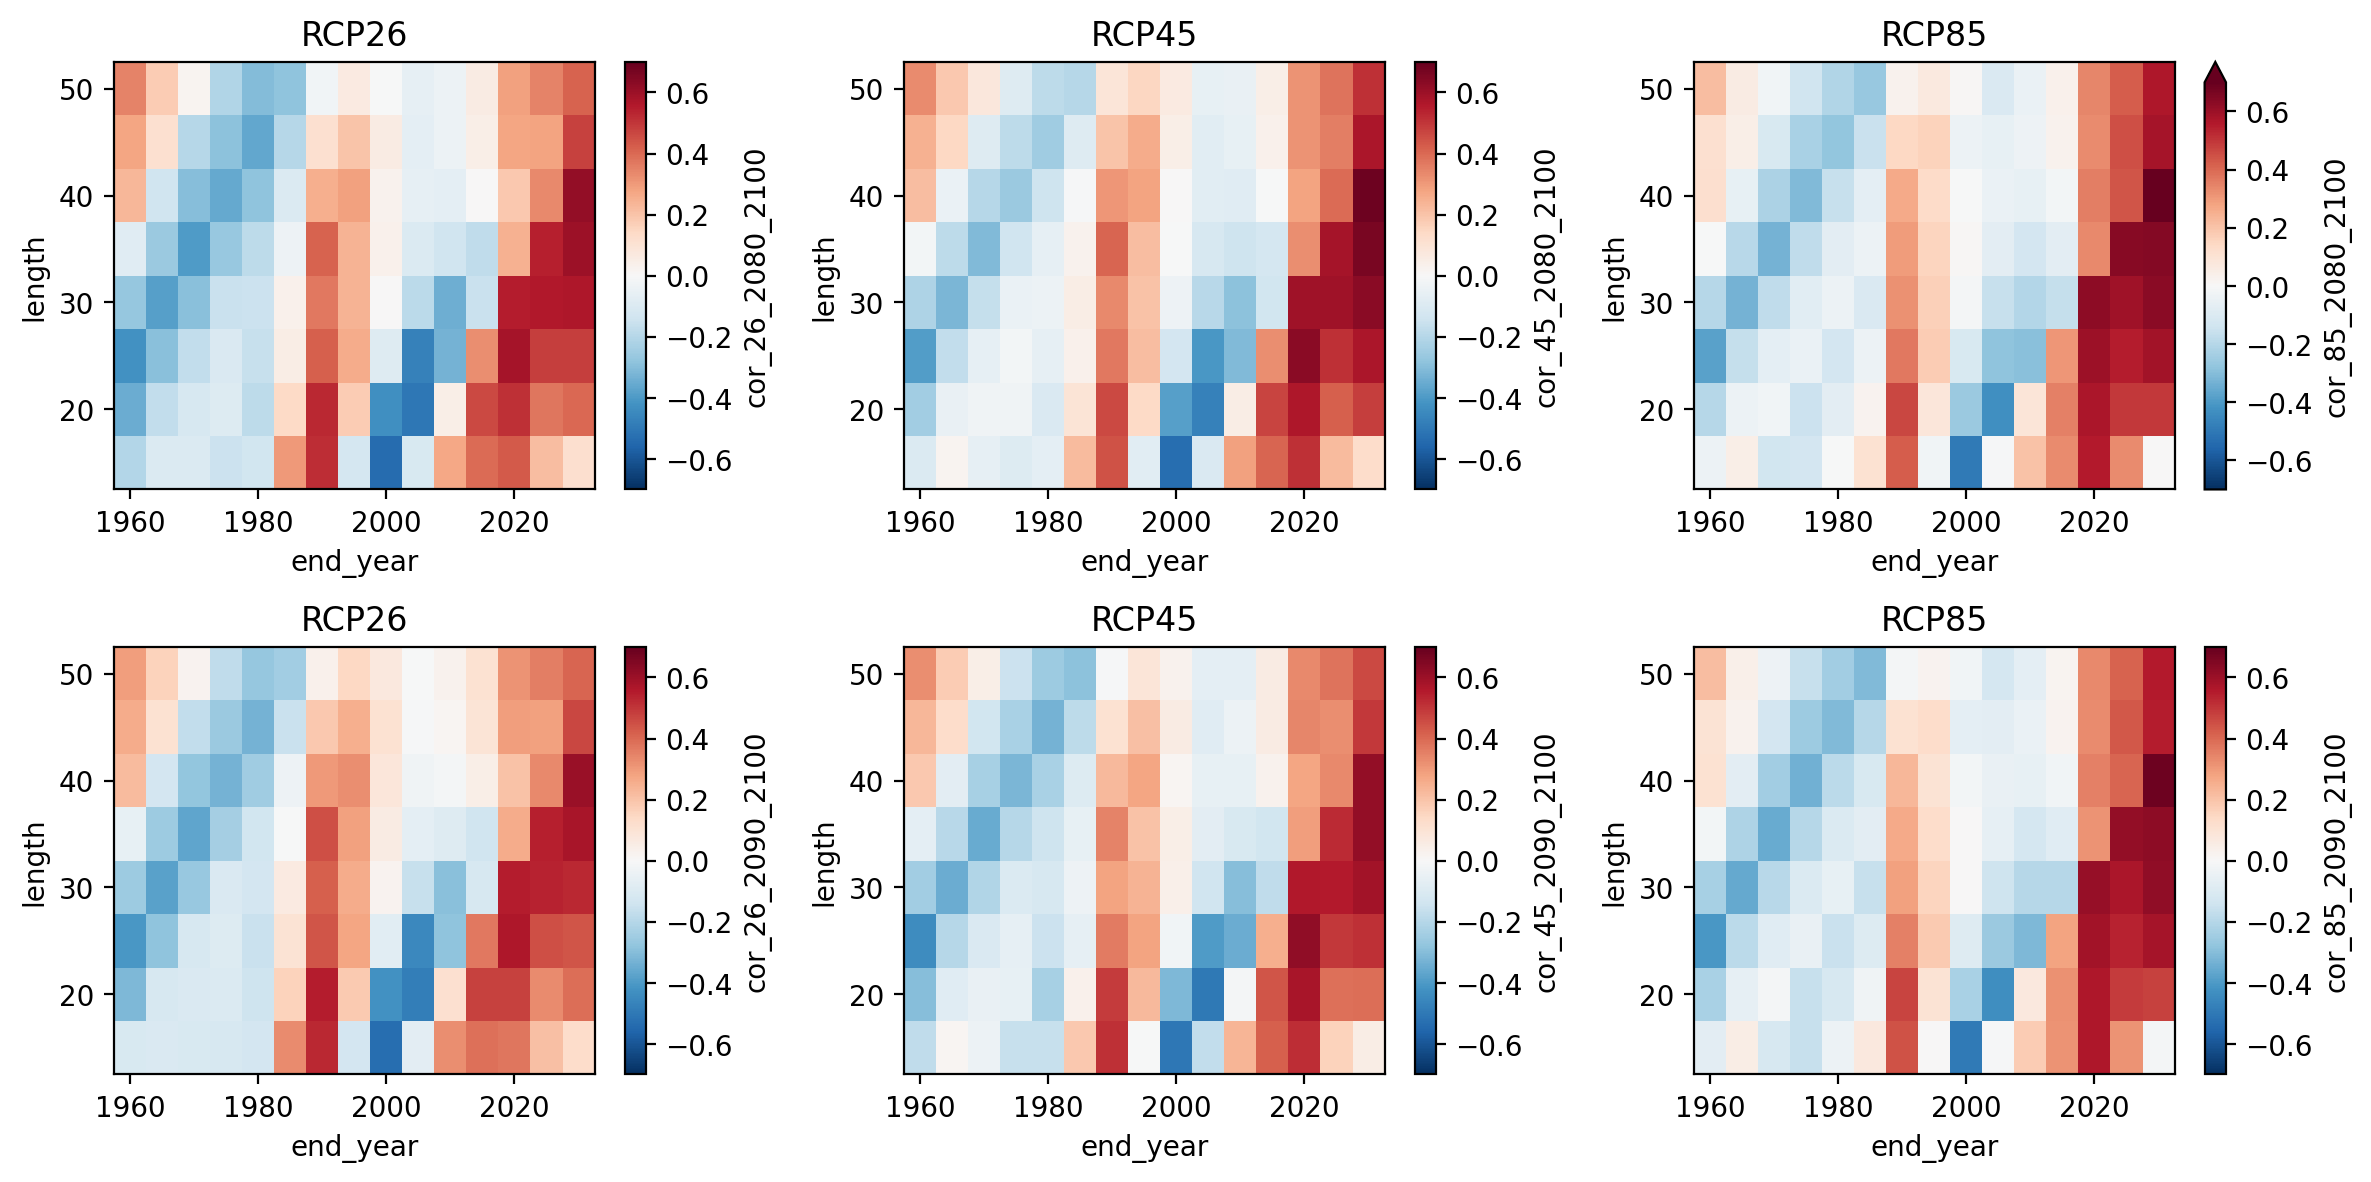

In [613]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for idx, sd in enumerate([2080,2090]):
    for idy, scen in enumerate([26, 45, 85]):
        cmip5_ds[f'cor_{scen}_{sd}_2100'].plot(ax=axes[idx,idy], vmin=-0.7, vmax=0.7, cmap='RdBu_r')
        axes[idx,idy].set_title(f'RCP{scen}')
    
plt.tight_layout()

### CMIP6

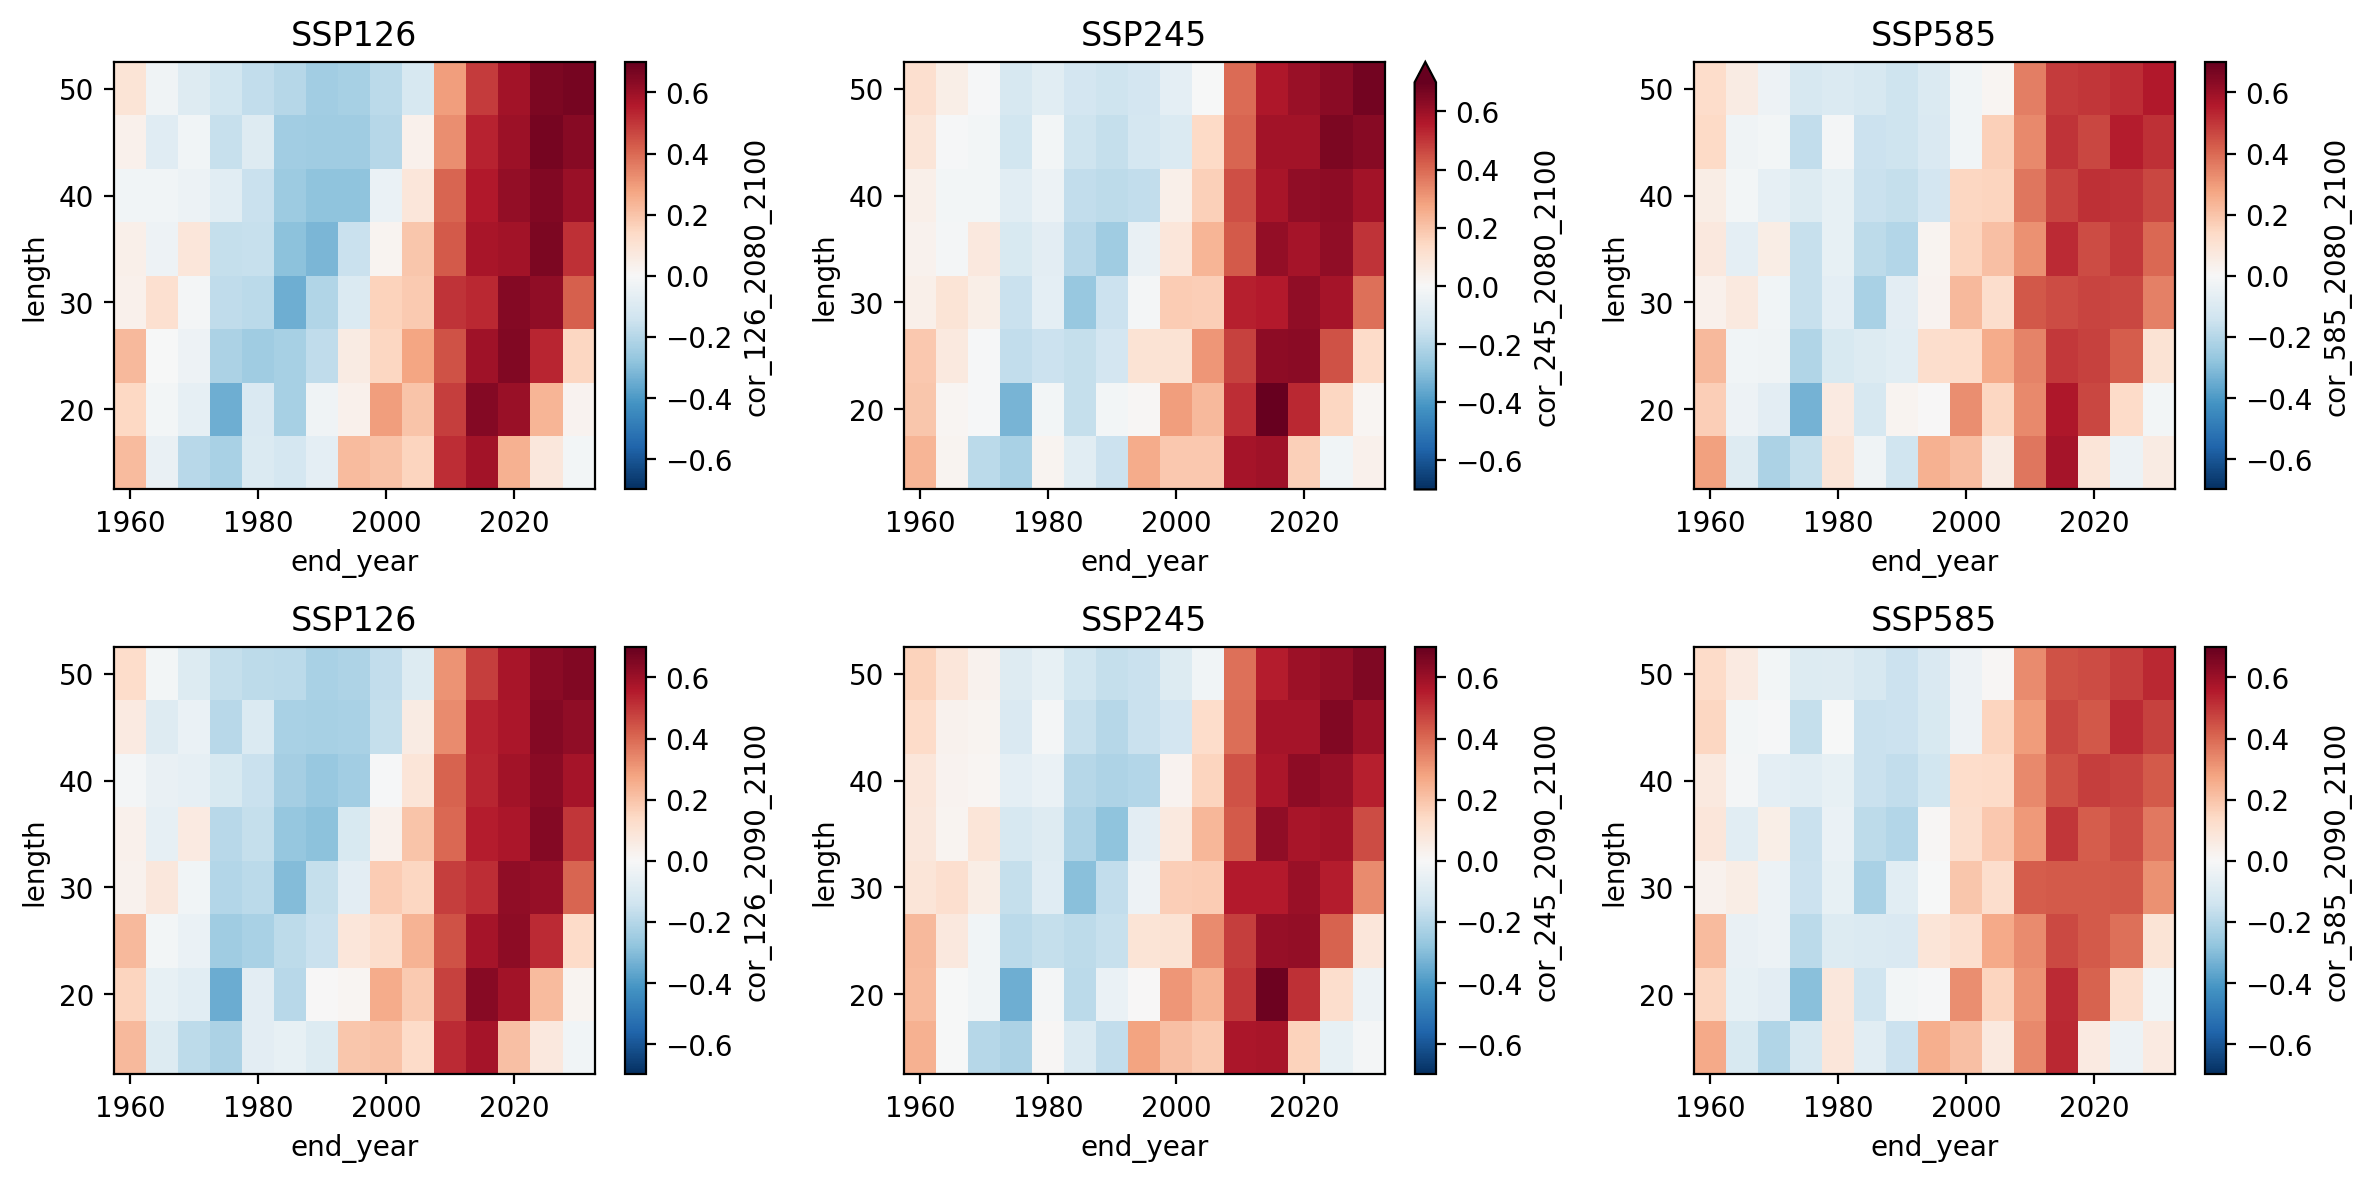

In [614]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for idx, sd in enumerate([2080,2090]):
    for idy, scen in enumerate([126, 245, 585]):
        cmip6_ds[f'cor_{scen}_{sd}_2100'].plot(ax=axes[idx,idy], vmin=-0.7, vmax=0.7, cmap='RdBu_r')
        axes[idx,idy].set_title(f'SSP{scen}')
    
plt.tight_layout()

### CMIP6 without wind

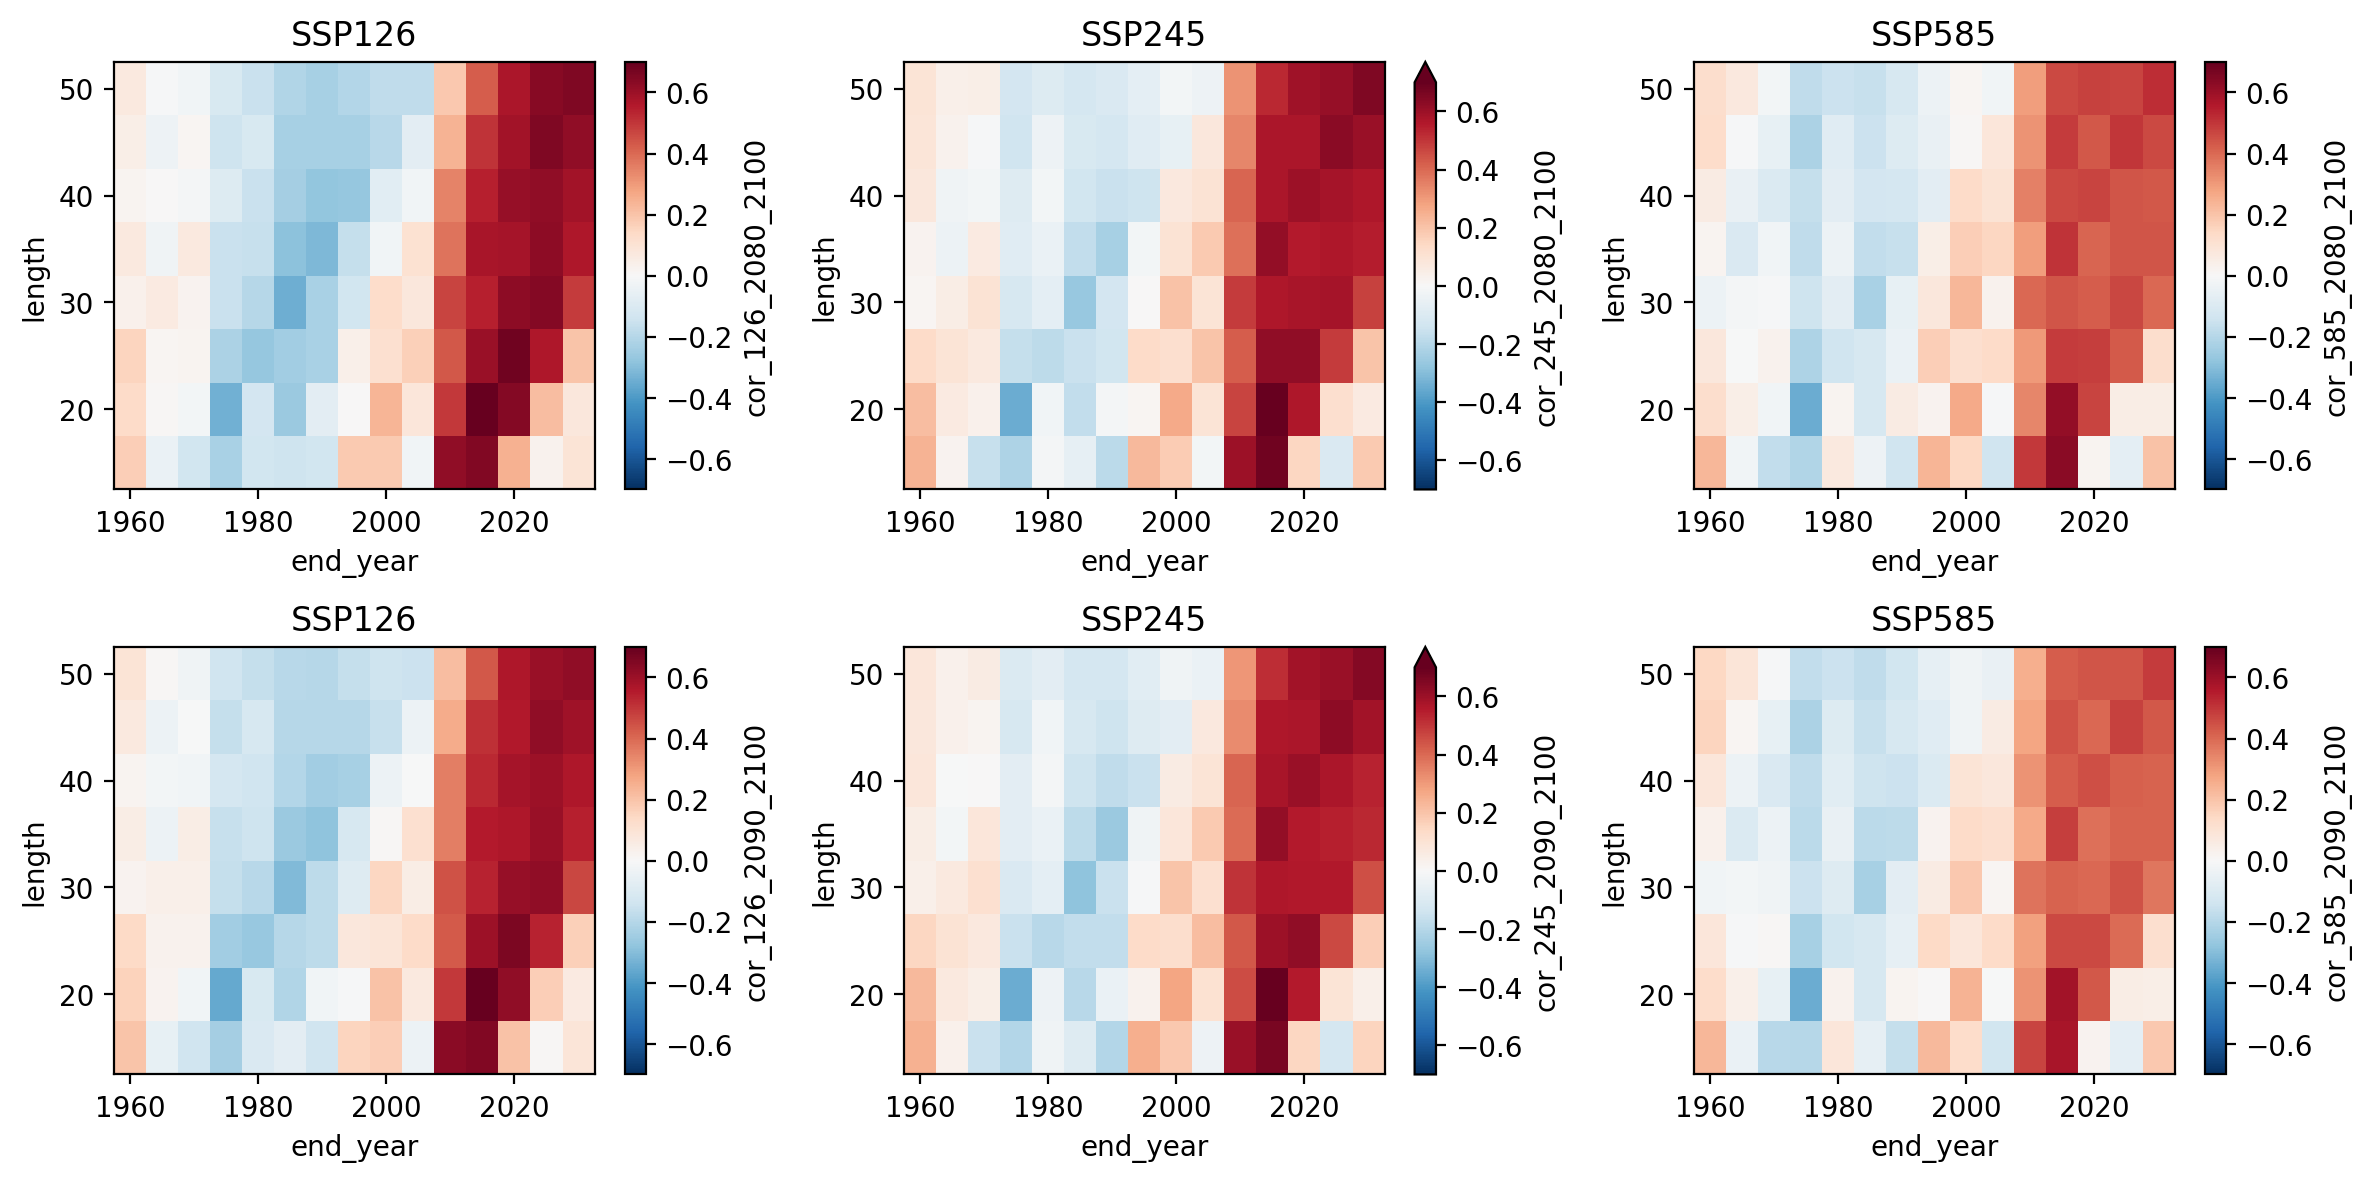

In [615]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for idx, sd in enumerate([2080,2090]):
    for idy, scen in enumerate([126, 245, 585]):
        cmip6_nowind_ds[f'cor_{scen}_{sd}_2100'].plot(ax=axes[idx,idy], vmin=-0.7, vmax=0.7, cmap='RdBu_r')
        axes[idx,idy].set_title(f'SSP{scen}')
    
plt.tight_layout()

### Difference CMIP6 with minus without wind

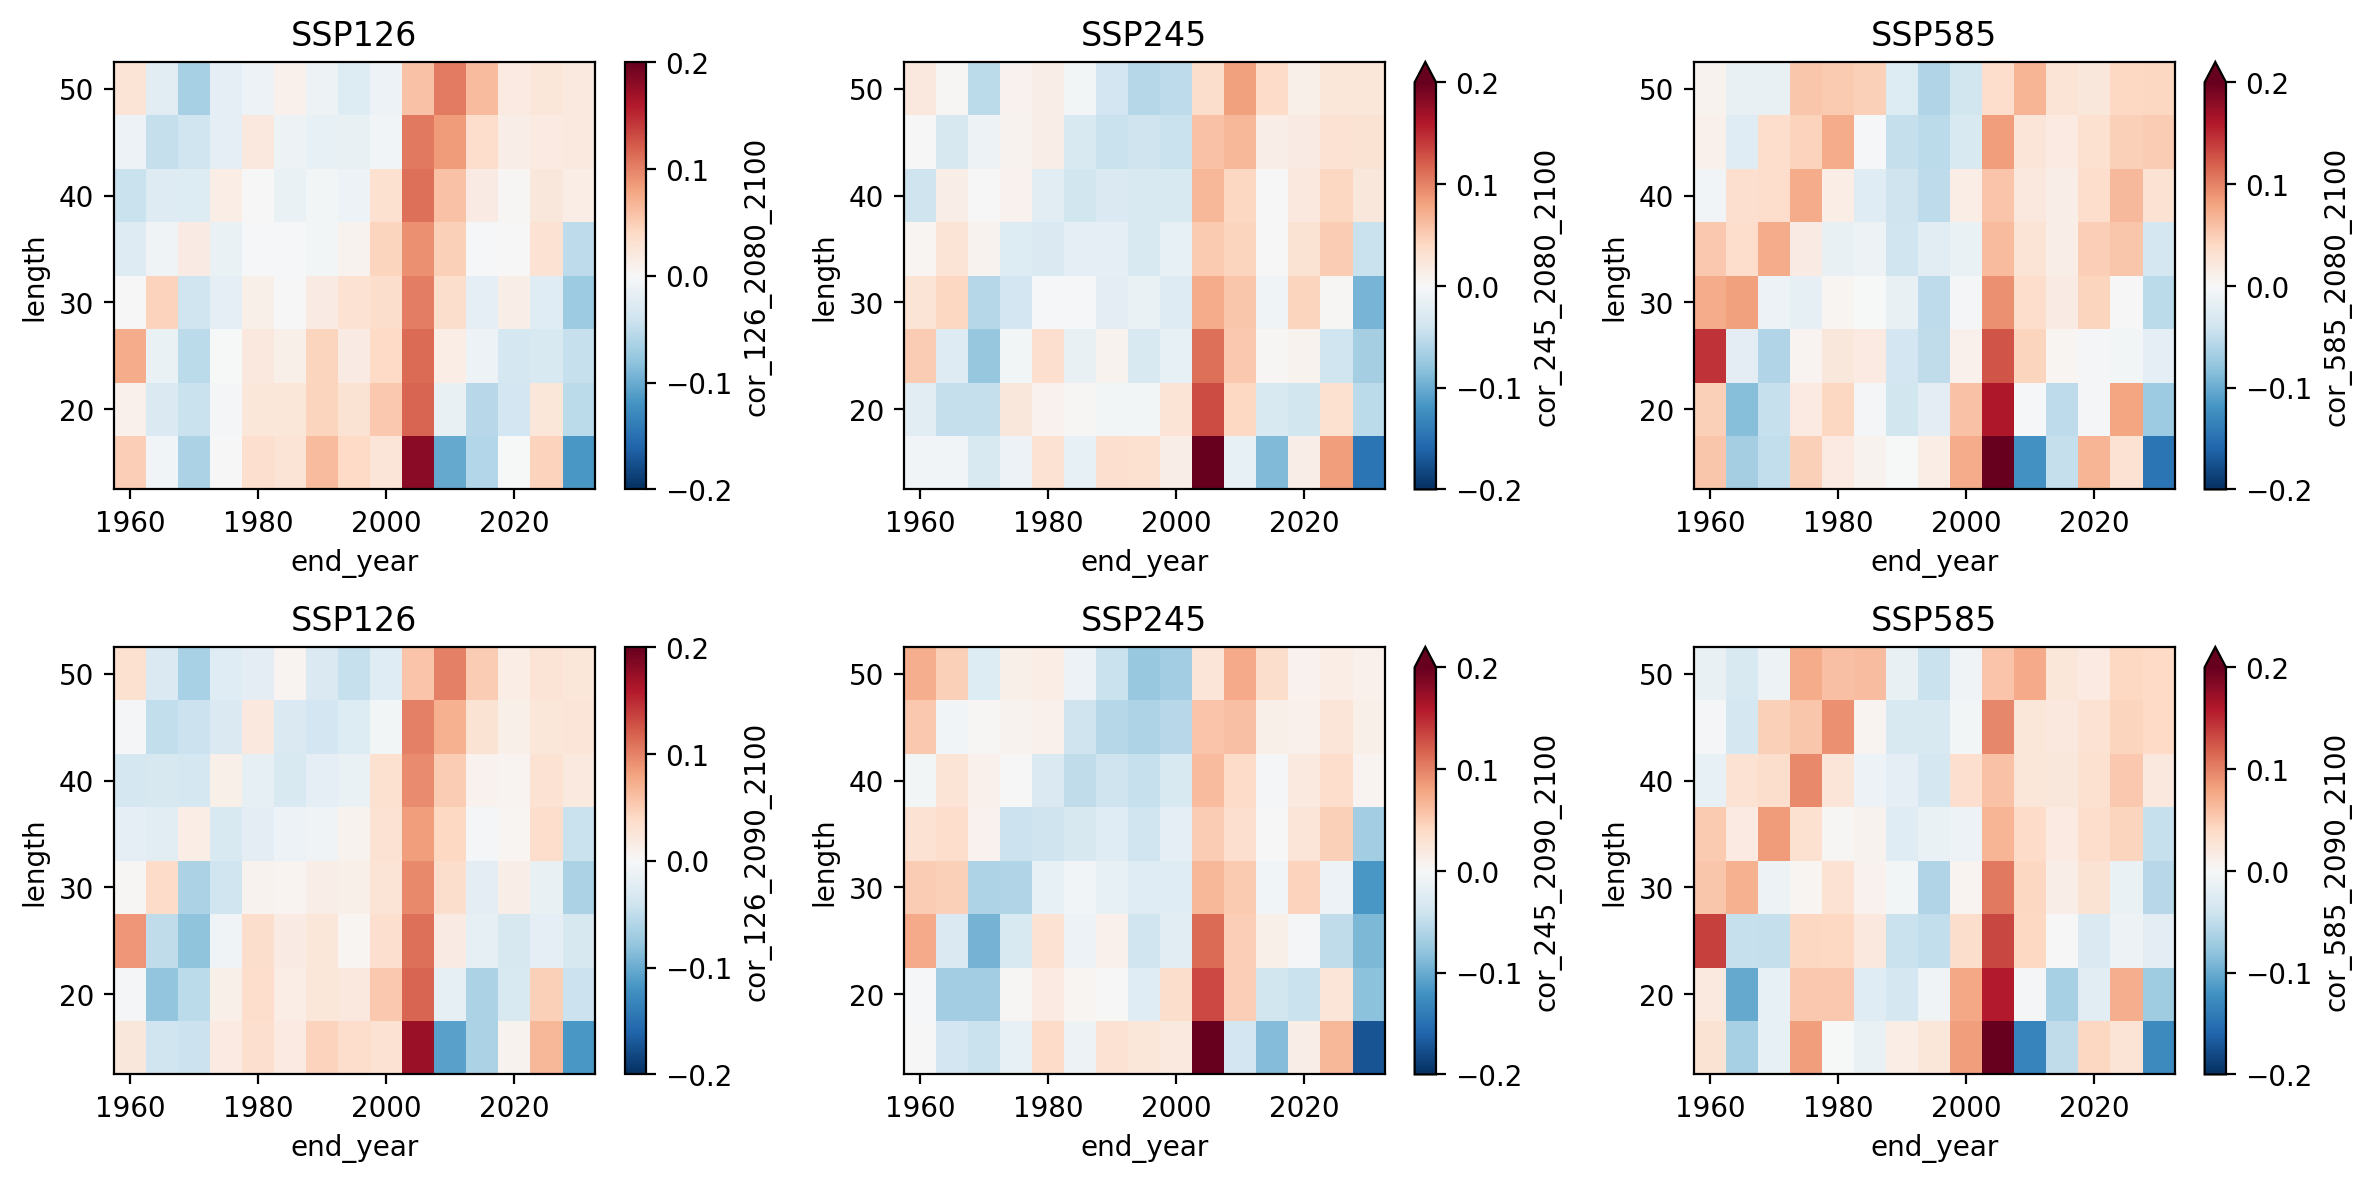

In [618]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for idx, sd in enumerate([2080,2090]):
    for idy, scen in enumerate([126, 245, 585]):
        diff = cmip6_ds[f'cor_{scen}_{sd}_2100'] - cmip6_nowind_ds[f'cor_{scen}_{sd}_2100']
        diff.plot(ax=axes[idx,idy], vmin=-0.2, vmax=0.2, cmap='RdBu_r')
        axes[idx,idy].set_title(f'SSP{scen}')
    
plt.tight_layout()

Conclusion from CMIP5/CMIP6 comparison: 
- High correlations arise earlier in CMIP6 than in CMIP5.
- For CMIP5 the correlation is higher for the high emission scenarios while for CMIP6 it is for the lowest emission scenario. Could that difference be related to the physics involved for different time periods? Yes, if we use the results of Franka then we saw that it was necessary for the use two regressors for CMIP6 while CMIP5 worked well with one. For the short term and low emission scenarios then AMOC is the main driver of ODSL change while for high emission scenarios then GSAT changes are more important.

Conclusion from the wind removal in CMIP6:
- Removing the wind increases the correlation for periods finishing in 2005 which is just the beginning of the moment when strong correlations between observed rates and future heights are detected.

Conclusion about this section:
- It seems that for CMIP6 there is no need to use more than 25/30 years, even without wind correction. We have 29 which is good. 

## Observed ODSL data

### Read budget data

In [659]:
path_slb = f'../SLBudget/outputs/'

budget_tg_df = pd.read_csv(path_slb+
                        'slbudget_2022_11_23_ZSM_tide_gauge_1993_2021_ERA5_StericEN4_22_[500, 4000]m.csv')

budget_alti_df = pd.read_csv(path_slb+
                        'slbudget_2022_12_01_NL_region_altimetry_1993_2021_ERA5_StericEN4_22_[500, 4000]m.csv')

budget_tg_df.set_index('time', inplace=True)
budget_alti_df.set_index('time', inplace=True)

#budget_tg_df = budget_tg_df.loc[1993:2021]

### Compute an uncertainty in observed steric sea level

In [909]:
data_source = ['IAP', 'EN4_22']
mask_name = ['EBB', 'NWS']
max_depth = [2000, 4000]

rate_ssl_df = pd.DataFrame(index=['slope', 'stderr'])

glo_steric_df = slc.contrib_frederikse2020_glob('GloSteric', extrap=True)

for data_s in data_source:
    for mask_n in mask_name:
        for max_d in max_depth:
            ssl = slc.StericSL(data_s, mask_n, 0, max_d, 0)
            ssl = ssl.Steric.loc[1993:2021]-glo_steric_df.GloSteric.loc[1993:2021]
            rate_ssl = linregress(ssl.index, ssl*10)
            
            rate_ssl_df[f'{data_s}_{mask_n}_{max_d}'] = [rate_ssl.slope, rate_ssl.stderr]

# IAP only provide data down to 2000m so values of 4000m are removed
rate_ssl_df = rate_ssl_df.drop(['IAP_EBB_4000','IAP_NWS_4000'], axis=1)

In [910]:
rate_ssl_df

IAP_EBB_2000  IAP_NWS_2000  EN4_22_EBB_2000  EN4_22_EBB_4000  \
slope       0.415894      0.536802         0.090077         0.320195   
stderr      0.314691      0.270691         0.295419         0.315711   

        EN4_22_NWS_2000  EN4_22_NWS_4000  
slope          0.709460         1.376768  
stderr         0.292548         0.316878

### Compute rates

In [765]:
budget_closure_alti = budget_alti_df.Obs - (budget_alti_df.Total-budget_alti_df.LocSteric)
rate_closure_alti = linregress(budget_closure_alti.index, budget_closure_alti*10)

budget_closure_tg = budget_tg_df.Obs - (budget_tg_df.Total-budget_tg_df.LocSteric)
rate_closure_tg = linregress(budget_closure_tg.index, budget_closure_tg*10)

rate_SODA = [0.45, 0.36]

In [661]:
rate_closure_tg

LinregressResult(slope=0.8258953704510911, intercept=-1594.602027811273, rvalue=0.41687676759934705, pvalue=0.02446570210311414, stderr=0.3465625806052057, intercept_stderr=695.5571429406288)

In [662]:
rate_closure_alti

LinregressResult(slope=0.6680119672785169, intercept=-1318.1050696607133, rvalue=0.3378825049038837, pvalue=0.07302765969862755, stderr=0.35810730032916327, intercept_stderr=718.7275967536843)

### First figure comparison observations and modelled ODSL minus wind

In [921]:
x_axis = ['Budget closure altimetry', 'Budget closure tide gauges', 'Reanalysis: SODA']
y_axis = [rate_closure_alti.slope, rate_closure_tg.slope, rate_SODA[0]]

y_error = [rate_closure_alti.stderr, rate_closure_tg.stderr, rate_SODA[1]]

# Add steric estimates to the list
for col in rate_ssl_df.columns:
    x_axis.append(col)
    y_axis.append(rate_ssl_df.loc['slope', col])
    y_error.append(rate_ssl_df.loc['stderr', col])

obs_nb = len(x_axis)

top_line = max(np.array(y_axis)+np.array(y_error))
bot_line = min(np.array(y_axis)-np.array(y_error))

In [922]:
# Add models to the list
x_axis.extend(list(cmip6_nowind_ds.model.data))
y_axis.extend(list(cmip6_nowind_ds.slope.sel(length=30, end_year=2020).data))
y_error.extend(list(cmip6_nowind_ds.stderr.sel(length=30, end_year=2020).data))

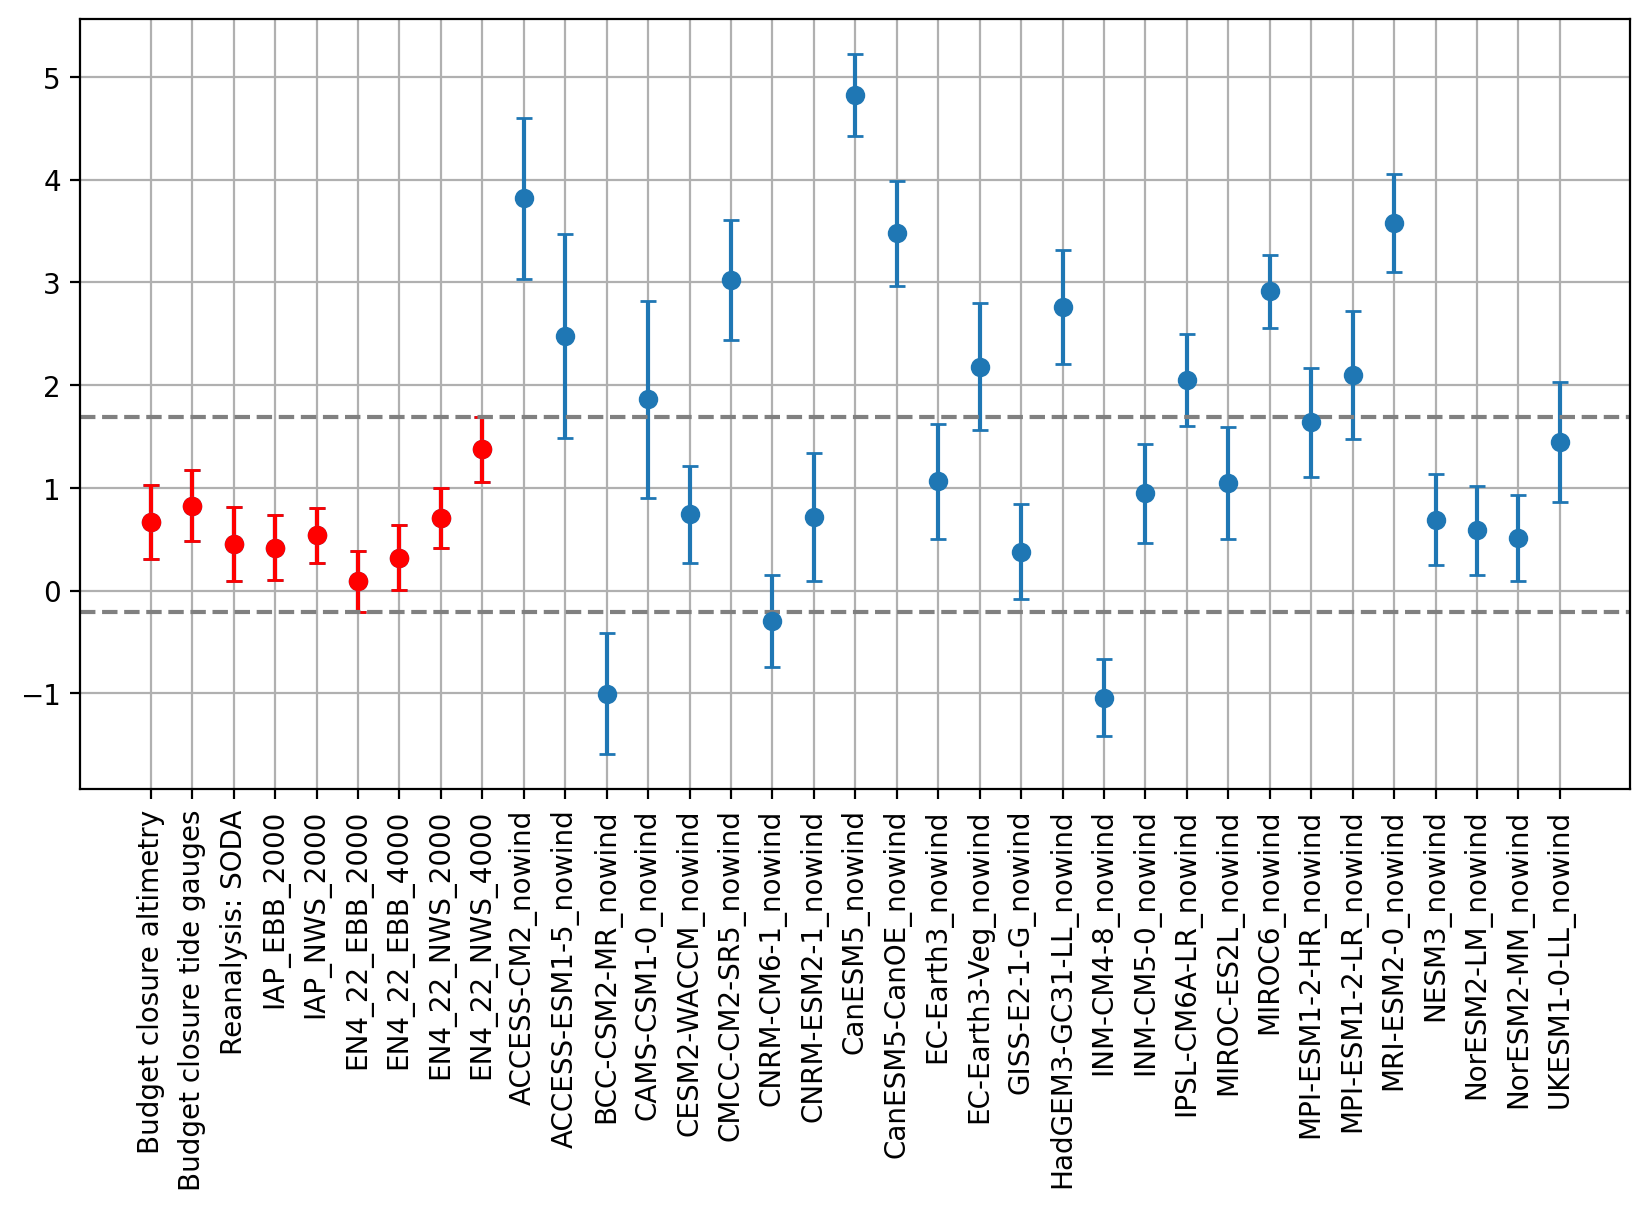

In [936]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(x_axis, y_axis, yerr=y_error, fmt="o", capsize = 3)

ax.errorbar(x_axis[:obs_nb], y_axis[:obs_nb], yerr=y_error[:obs_nb], fmt="o", capsize = 3, c='red')

plt.axhline(y=top_line, color='grey', linestyle='--')
plt.axhline(y=bot_line, color='grey', linestyle='--')

plt.xticks(rotation = 90)
plt.grid()

### Second figure comparison observations and modelled ODSL minus wind (aggregated and including CMIP5)

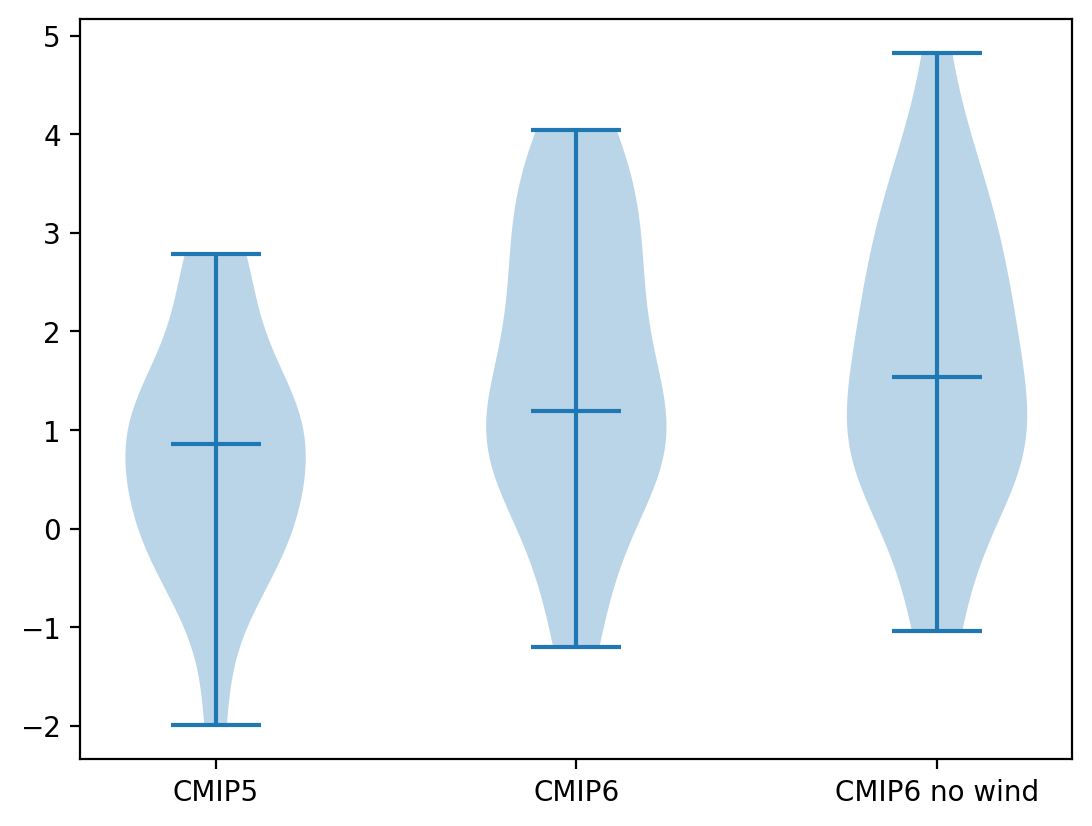

In [924]:
fig, ax = plt.subplots()

data = [list(cmip5_ds.slope.sel(length=30, end_year=2020).data), 
        list(cmip6_ds.slope.sel(length=30, end_year=2020).data), 
        list(cmip6_nowind_ds.slope.sel(length=30, end_year=2020).data)]

ax.violinplot(data, [1, 2, 3], 
               showextrema=True, 
               showmedians=True)

labels = ['CMIP5', 'CMIP6', 'CMIP6 no wind']
#plt.set_axis_style(ax, labels)

plt.xticks([1, 2, 3], labels=['CMIP5', 'CMIP6', 'CMIP6 no wind']);

## Model selection

### List of model selected for a Latex table

In [925]:
ds = cmip6_nowind_ds

cond1 = ds.slope.sel(length=30, end_year=2020) - ds.stderr.sel(length=30, end_year=2020) < top_line
cond2 = ds.slope.sel(length=30, end_year=2020) + ds.stderr.sel(length=30, end_year=2020) > bot_line

model_sel = [a.split('_')[0] for a in ds.model.isel(model=(cond1&cond2).data).data]
model_too_high = [a.split('_')[0] for a in ds.model.isel(model=(~cond1).data).data]
model_too_low = [a.split('_')[0] for a in ds.model.isel(model=(~cond2).data).data]

print(f"Total number of CMIP6 models with wind correction: {len(ds.model)}")
print(f"{len(model_sel)} models are selected: ")
print(list(model_sel))

print(f"{len(model_too_high)} models have too high rates: ")
print(list(model_too_high))

print(f"{len(model_too_low)} models have too low rates: ")
print(list(model_too_low))

Total number of CMIP6 models with wind correction: 26
17 models are selected: 
['ACCESS-ESM1-5', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'EC-Earth3', 'EC-Earth3-Veg', 'GISS-E2-1-G', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']
7 models have too high rates: 
['ACCESS-CM2', 'CMCC-CM2-SR5', 'CanESM5', 'CanESM5-CanOE', 'HadGEM3-GC31-LL', 'MIROC6', 'MRI-ESM2-0']
2 models have too low rates: 
['BCC-CSM2-MR', 'INM-CM4-8']


In [926]:
# List used for last version of KNMI'23:
knmi23_list = ['ACCESS-ESM1-5', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 
               'EC-Earth3', 'FGOALS-f3-L', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NESM3', 'NorESM2-LM', 
               'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']
print(len(knmi23_list))
knmi23_list

14


['ACCESS-ESM1-5',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'EC-Earth3',
 'FGOALS-f3-L',
 'MIROC-ES2L',
 'MPI-ESM1-2-LR',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

### Impact of model selection on projection

In [927]:
def plot_comp_ensembles(name_ens1, ens1_df, name_ens2, ens2_df, 
                        lower_bound, upper_bound, ra):
    '''Takes two dataframes from model ensembles as inputs and make a figure of 
    median and some quantiles to represente the divergence between models of the 
    ensemble.'''
    
    sce = f'{name_ens1}_{name_ens2}'
    
    ens1_med = ens1_df.mean(axis=1).rolling(ra, center=True).mean()
    ens1_lb = ens1_df.quantile(lower_bound, axis=1).rolling(ra, center=True).mean()
    ens1_ub = ens1_df.quantile(upper_bound, axis=1).rolling(ra, center=True).mean()

    ens2_med = ens2_df.mean(axis=1).rolling(ra, center=True).mean()
    ens2_lb = ens2_df.quantile(lower_bound, axis=1).rolling(ra, center=True).mean()
    ens2_ub = ens2_df.quantile(upper_bound, axis=1).rolling(ra, center=True).mean()

    fig, ax = plt.subplots(figsize=(6,6))
    ax.fill_between(ens1_ub.index, 
                    ens1_ub, 
                    ens1_lb, 
                    color='blue', alpha=0.5,
                    label=f'{name_ens1}, {int(lower_bound*100)}-{int(upper_bound*100)} percentiles')

    ax.fill_between(ens2_ub.index, 
                    ens2_ub, 
                    ens2_lb, 
                    color='orange', alpha=0.5,
                    label=f'{name_ens2}, {int(lower_bound*100)}-{int(upper_bound*100)} percentiles')

    ax.plot(ens1_med, color='blue', label=f'{name_ens1} mean')
    ax.plot(ens2_med, color='orange', label=f'{name_ens2} mean')

    plt.xlabel('time')
    plt.ylabel('sea level (cm)')
    plt.title(f'Compare zos projections from cmip5 and cmip6 for {sce} \n'+
              f'with reference period 1986-2005 and running average of {ra} years')
    ax.grid(True)
    plt.legend(loc='upper left')

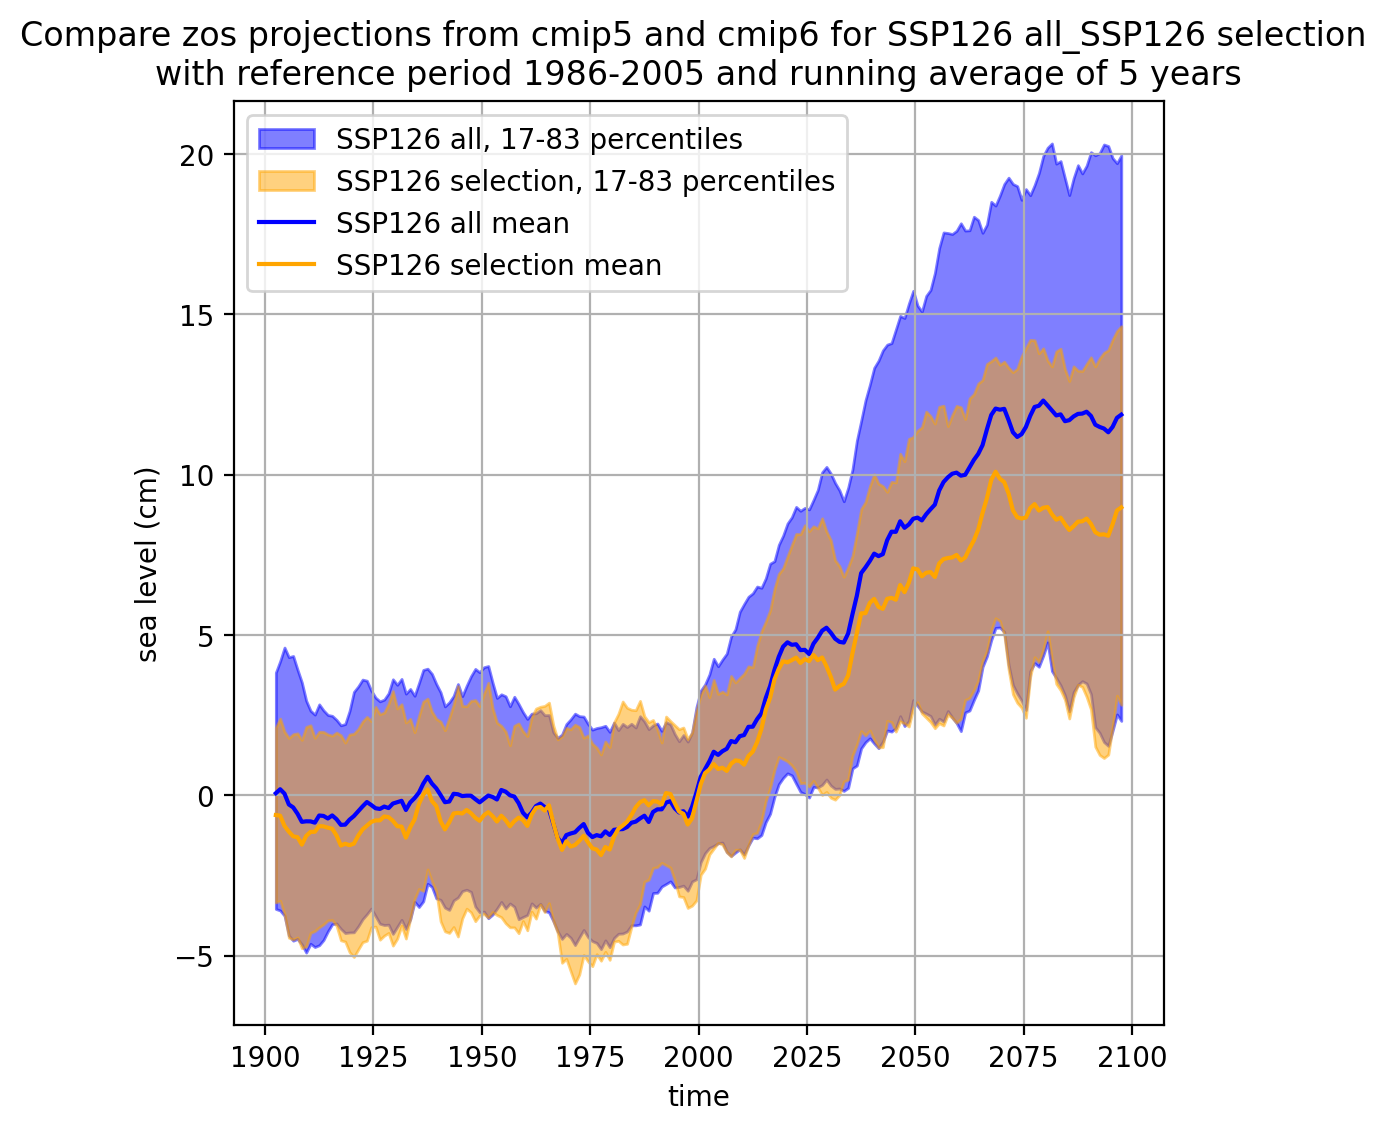

In [928]:
lower_bound = 0.17
upper_bound = 0.83
ra = 5 # runnning average window in years

plot_comp_ensembles('SSP126 all', cmip6_126_df, 'SSP126 selection', cmip6_126_df[model_sel], 
                   lower_bound, upper_bound, ra)


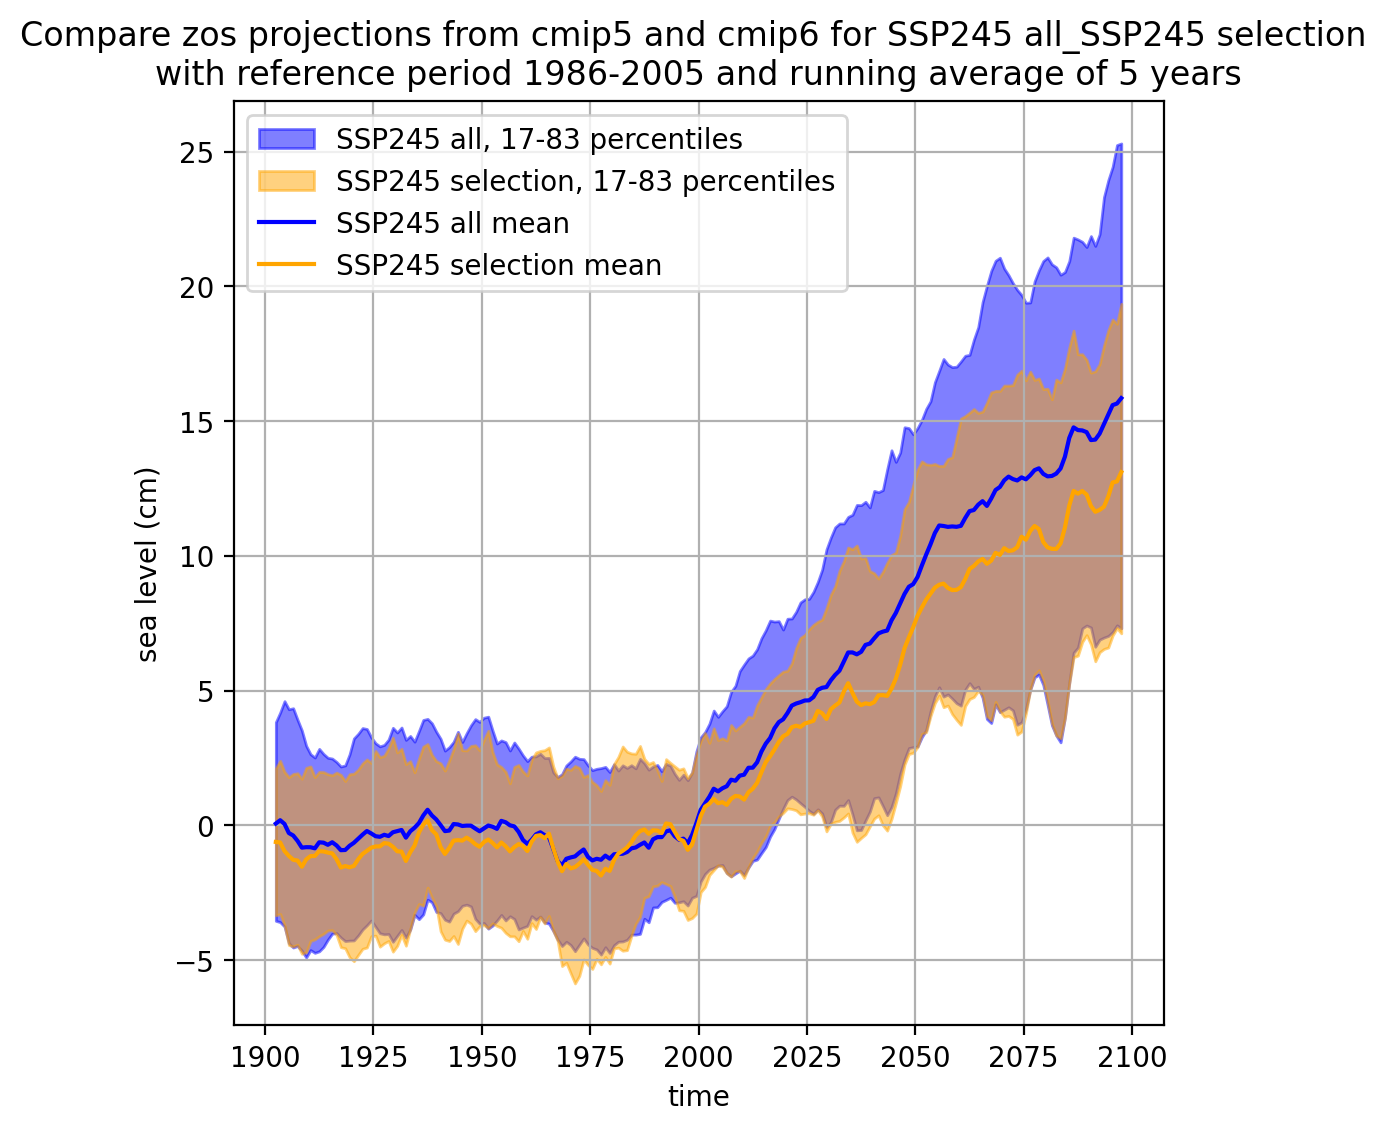

In [929]:
plot_comp_ensembles('SSP245 all', cmip6_245_df, 'SSP245 selection', cmip6_245_df[model_sel], 
                   lower_bound, upper_bound, ra)

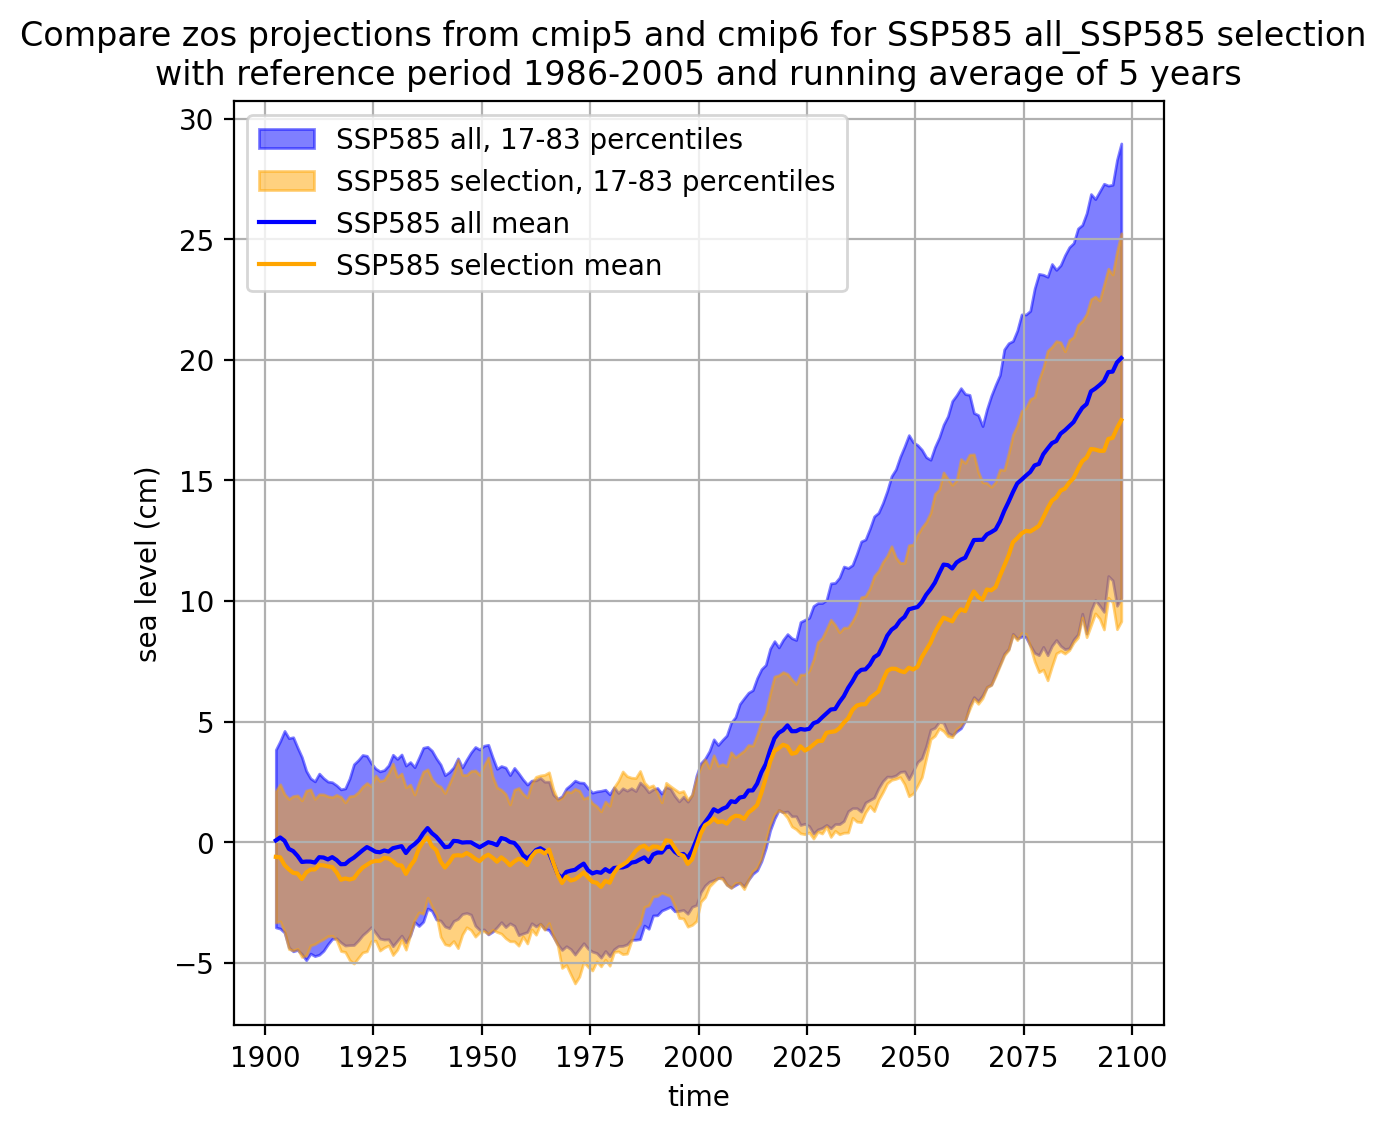

In [930]:
plot_comp_ensembles('SSP585 all', cmip6_585_df, 'SSP585 selection', cmip6_585_df[model_sel], 
                   lower_bound, upper_bound, ra)

<AxesSubplot: xlabel='time'>

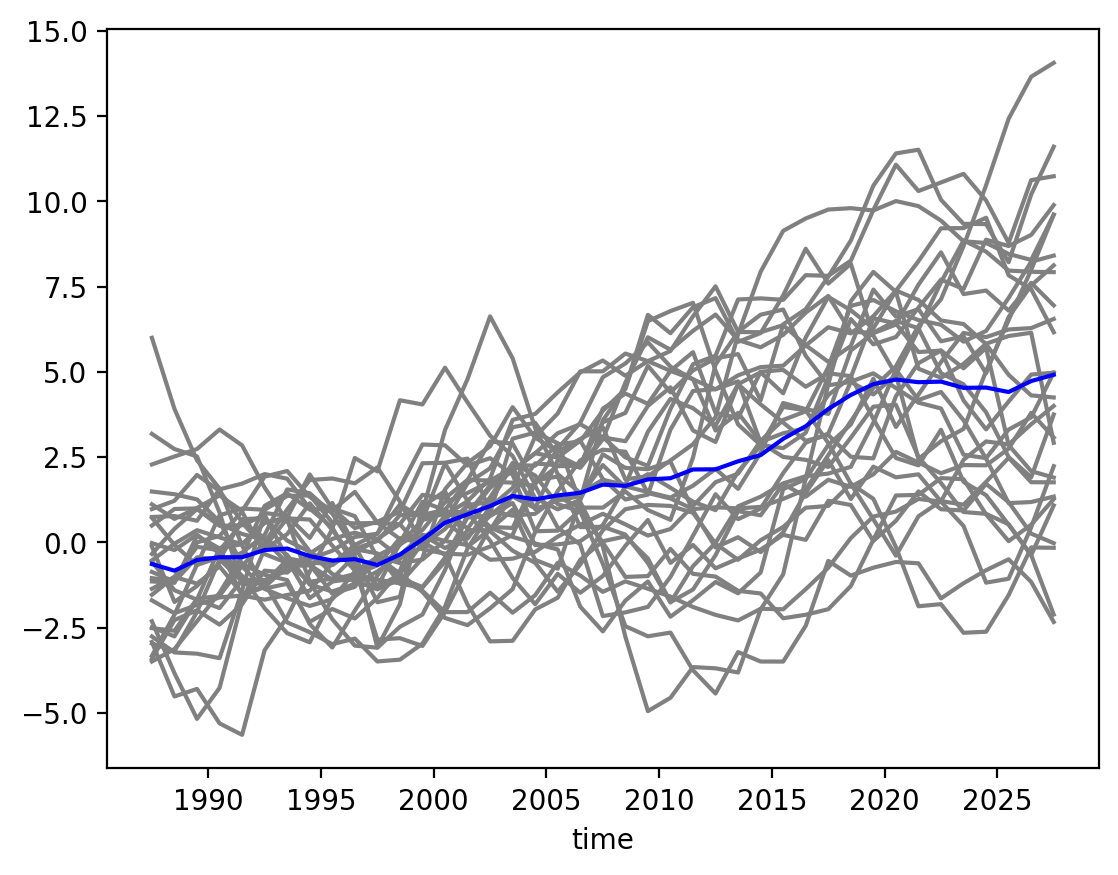

In [931]:
cmip6_126_df.loc[1985:2030].rolling(ra, center=True).mean().plot(legend=False, color='grey')
cmip6_126_df.loc[1985:2030].mean(axis=1).rolling(ra, center=True).mean().plot(legend=False, color='blue')

#plt.legend()

<AxesSubplot: xlabel='time'>

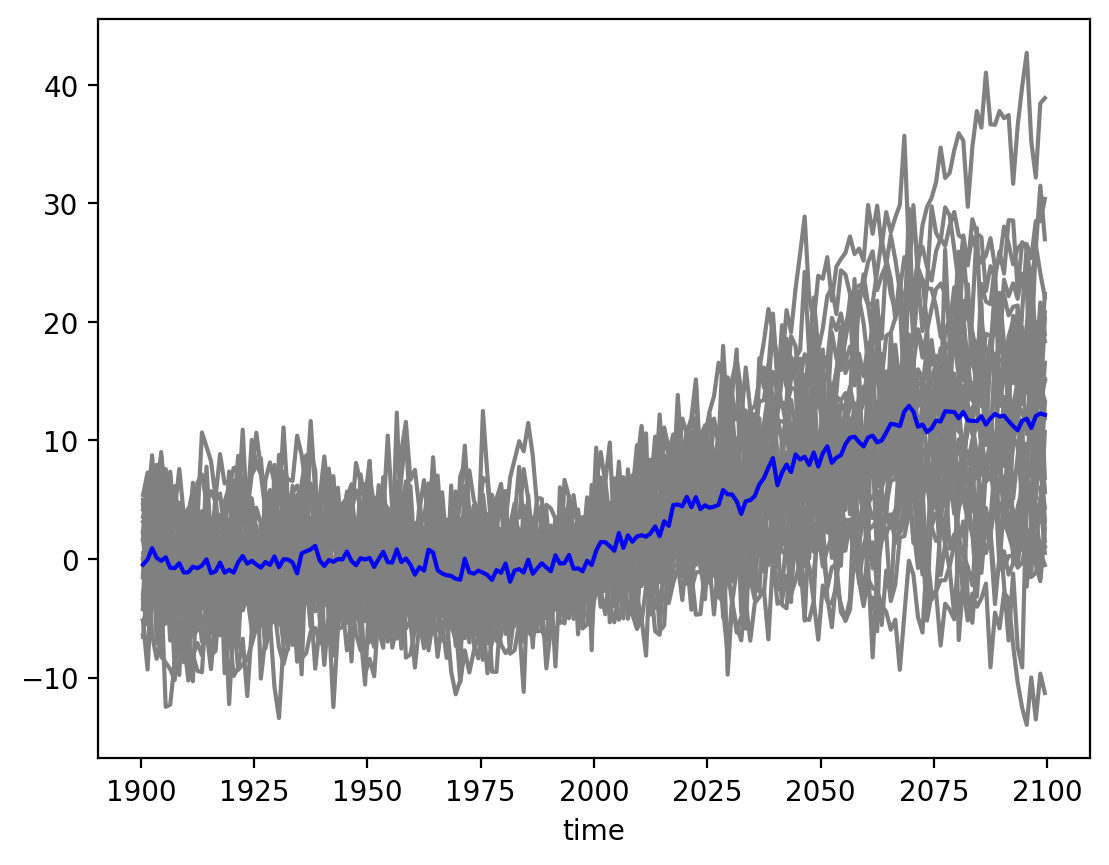

In [941]:
cmip6_126_df.plot(legend=False, color='grey')
cmip6_126_df.mean(axis=1).plot(legend=False, color='blue')

<AxesSubplot: xlabel='time'>

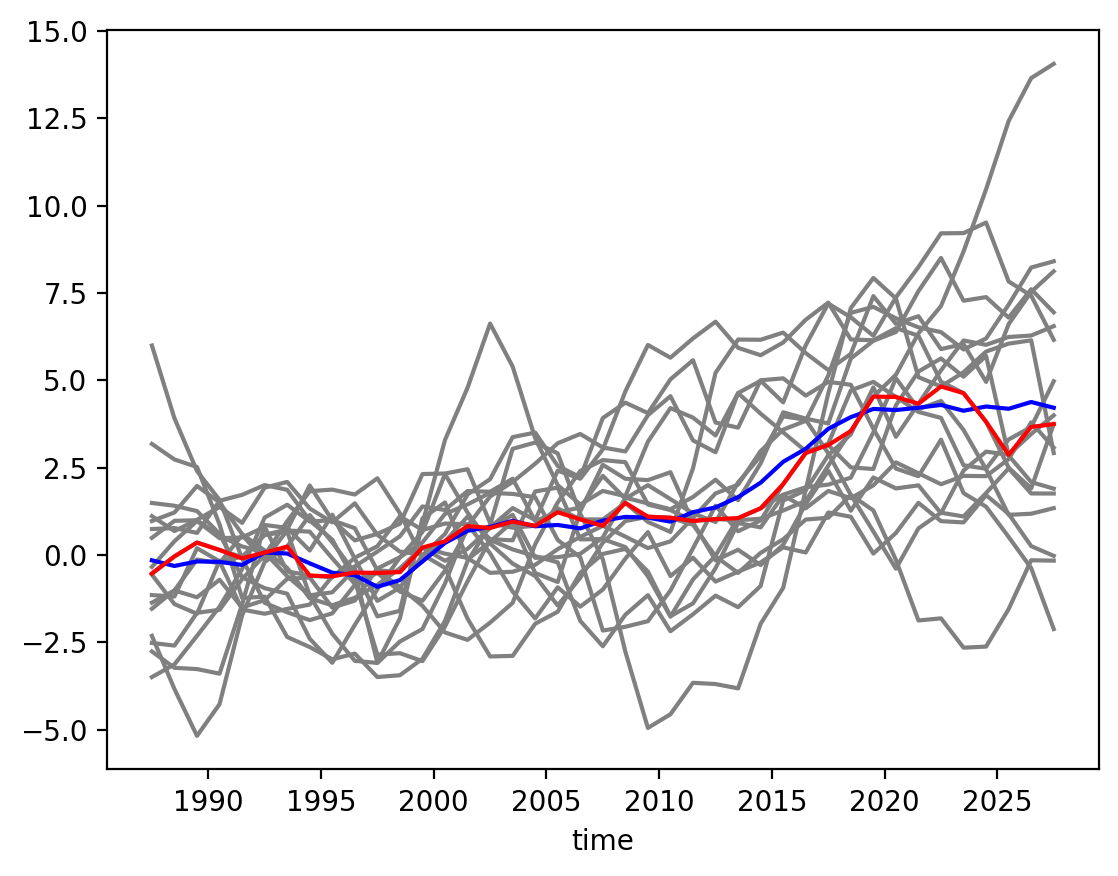

In [937]:
sel_with_ra = cmip6_126_df[model_sel].loc[1985:2030].rolling(ra, center=True).mean()
sel_with_ra.plot(color='grey', legend=False)
sel_with_ra.mean(axis=1).plot(legend=False, color='blue')
sel_with_ra.quantile(0.50, axis=1).plot(legend=False, color='red')



<AxesSubplot: xlabel='time'>

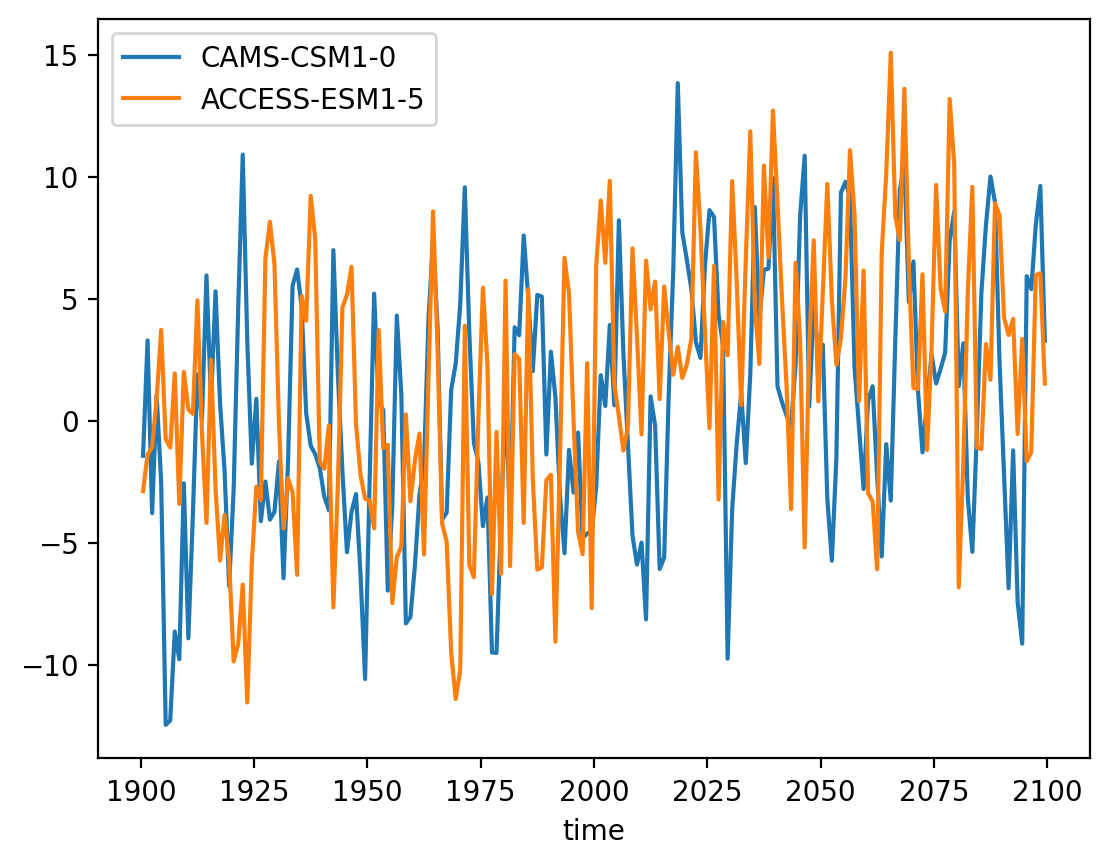

In [933]:
cmip6_126_df['CAMS-CSM1-0'].plot(legend=True)
cmip6_126_df['ACCESS-ESM1-5'].plot(legend=True)

To do:
- Update the correlation plots to contain the exact period that we use from the budgets and highlight that in the plot.
- Make a figure showing the regions used
- Add the reanalysis to the plot (when I received the inputs from Iris)

Not to do anymore:
- Get CMIP6 piControl data from KNMI to compute the influence of natural variability on the rates.
- Recompute CMIP5 piControl data and import locally to compute trend uncertainty
- Add uncertainty to the budget computation: Check rates from AR6, IMBIE paper for AA: This is not straight forward and it would not change the results.

Remarks for the paper: 

How can we combine CMIP5/CMIP6 and wind/no wind results in the best way? The paper will focus exclusively on CMIP6 models so this issue is not relevant anymore.
- Use the wind correction to show that it is not very important for the emergent constrain method but it might be for other reasons like comparing with observations.
- Since it is not very important for the emergent constraint then we can also use CMIP5.
- Discussion point: Models with a large uncertainty in trend computation, due to large variability in the time series, will have more chance to be selected. This is rather unfair, especially if that variability seems unrealistic. However, fixing this would make the method more complex, it would involve another selection process

Remarks:
- One disadvantage of this selection method is that models with the largest natural variability are more likely to be chosen.
- This issue could be mitigated by selecting models also depending on their natural variability. But then we need an estimate of what it is in the observations.